In [19]:
import sys
sys.path.append(r"C:\Users\trund\QRT")

from backtest.backtesting import FunctionStrategy, Backtester # To backtest the strategy
from sklearn.preprocessing import StandardScaler
import backtest.backtest_results as btr
import eda_pipeline 
import eda_package.descriptive as eda

from typing import Optional, List, Tuple, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import scipy.stats as stats
import yfinance as yf

# Repeated Function Calls

In [74]:
def obtain_data():

    tickers = [
        "JPM",   # JPMorgan (NYSE)
        "GS",    # Goldman Sachs (NYSE)
        "MS",    # Morgan Stanley (NYSE)
        "BAC",   # Bank of America (NYSE)
        "C",     # Citigroup (NYSE)
        "UBS",   # UBS (NYSE / SIX)
        "BARC.L",# Barclays (LSE)
        "HSBA.L",# HSBC (LSE)
        "BNP.PA" # BNP Paribas (Euronext Paris)
    ]


    dates = (pd.Timestamp("2022-01-01"), pd.Timestamp("2024-12-31"))
    interval = "1d"

    data = yf.download(tickers, start=dates[0], end=dates[1], interval=interval, auto_adjust=False).dropna()
    # Replace whitespace in the field level of the MultiIndex columns
    data.columns = data.columns.set_levels(
        data.columns.levels[0].str.replace(" ", "_"),
        level=0,
        verify_integrity=False,
    )
    #data.columns = [f"{ticker}_{col}" for col, ticker in data.columns]

    data = data.dropna()
    for ticker in tickers:
        data[("Returns", ticker)] = data["Adj_Close"][ticker].pct_change()

    return data.dropna()

def obtain_data_with_fe():
    data = obtain_data()

    data["Returns"] = data["Returns"].clip(lower=data["Returns"].quantile(0.01, axis=0), upper=data["Returns"].quantile(0.99, axis=0), axis=1)

    return data

In [16]:
tickers = [
    "JPM",   # JPMorgan (NYSE)
    "GS",    # Goldman Sachs (NYSE)
    "MS",    # Morgan Stanley (NYSE)
    "BAC",   # Bank of America (NYSE)
    "C",     # Citigroup (NYSE)
    "UBS",   # UBS (NYSE / SIX)
    "BARC.L",# Barclays (LSE)
    "HSBA.L",# HSBC (LSE)
    "BNP.PA" # BNP Paribas (Euronext Paris)
]


dates = (pd.Timestamp("2022-01-01"), pd.Timestamp("2024-12-31"))
interval = "1d"

data = yf.download(tickers, start=dates[0], end=dates[1], interval=interval, auto_adjust=False)
#data.columns = [f"{ticker}_{col}" for col, ticker in data.columns]

data.dropna()

[*********************100%***********************]  9 of 9 completed


Price       Adj Close                                                \
Ticker            BAC      BARC.L     BNP.PA          C          GS   
Date                                                                  
2022-01-04  43.349213  196.358505  46.896557  54.531166  368.194397   
2022-01-05  42.617538  197.616547  46.955872  53.896572  360.197693   
2022-01-06  43.475670  200.142685  47.593517  55.663120  358.661469   
2022-01-07  44.424122  204.935318  47.823364  56.409184  359.185638   
2022-01-10  44.198303  207.581253  47.452641  56.623573  360.685608   
...               ...         ...        ...        ...         ...   
2024-12-20  43.170147  260.182281  52.228302  66.973167  554.777954   
2024-12-23  42.896484  261.531952  52.191956  67.534569  559.364502   
2024-12-24  43.375393  263.481384  52.282822  68.725174  571.134155   
2024-12-27  43.336296  264.831085  53.191456  68.725174  564.656372   
2024-12-30  42.916035  264.681091  53.364094  68.134720  562.078979   

Price                                                          Close  ...  \
Ticker          HSBA.L         JPM          MS        UBS        BAC  ...   
Date                                                                  ...   
2022-01-04  470.274963  150.423752   90.504738  16.657032  47.990002  ...   
2022-01-05  467.083221  147.673691   88.265121  16.451279  47.180000  ...   
2022-01-06  477.007385  149.242538   89.775558  17.014866  48.130001  ...   
2022-01-07  481.046844  150.721298   90.322456  17.310076  49.180000  ...   
2022-01-10  490.721710  150.865570   90.391891  17.211670  48.930000  ...   
...                ...         ...         ...        ...        ...  ...   
2024-12-20  760.398438  231.629700  119.419380  28.840673  44.169998  ...   
2024-12-23  764.696167  232.399857  120.396477  29.334587  43.889999  ...   
2024-12-24  771.592529  236.221359  122.921455  29.586384  44.380001  ...   
2024-12-27  776.689941  235.109985  122.631233  29.721970  44.340000  ...   
2024-12-30  781.287415  233.306488  121.654129  29.634808  43.910000  ...   

Price            Open      Volume                                     \
Ticker            UBS         BAC      BARC.L     BNP.PA           C   
Date                                                                   
2022-01-04  18.500000  74606700.0  40400336.0  3614427.0  30303600.0   
2022-01-05  18.660000  57791600.0  28170350.0  3910434.0  25149100.0   
2022-01-06  18.920000  52040900.0  29020547.0  3645405.0  33334200.0   
2022-01-07  19.299999  59082600.0  40109355.0  3446590.0  26548200.0   
2022-01-10  19.230000  66839500.0  38889136.0  3137609.0  28693700.0   
...               ...         ...         ...        ...         ...   
2024-12-20  29.639999  74222200.0  68228161.0  4839471.0  27720100.0   
2024-12-23  30.070000  35374800.0  13605305.0  1395481.0   8248000.0   
2024-12-24  30.340000  12054400.0   8298189.0   479686.0   6544900.0   
2024-12-27  30.660000  17972500.0  15970484.0  2338135.0   7743100.0   
2024-12-30  30.459999  16109800.0  14724719.0  1667203.0   6664400.0   

Price                                                                 
Ticker             GS      HSBA.L         JPM          MS        UBS  
Date                                                                  
2022-01-04  3916400.0  36059821.0  20195800.0   8967000.0  2363300.0  
2022-01-05  3469600.0  27632008.0  17539400.0  10288800.0  2868200.0  
2022-01-06  2960900.0  35001580.0  14047500.0  10059200.0  4109400.0  
2022-01-07  2360700.0  31774685.0  13913300.0   6128400.0  3074600.0  
2022-01-10  3009400.0  34726983.0  12922500.0   8904900.0  3539900.0  
...               ...         ...         ...         ...        ...  
2024-12-20  4515900.0  75955984.0  32348400.0  14884000.0  2302300.0  
2024-12-23  1519500.0  13697932.0   8611500.0   5074100.0  1801500.0  
2024-12-24   913400.0   3604795.0   3729100.0   2902800.0   583900.0  
2024-12-27  1486000.0  13069986.0   5730200.0   3088100.0  109500

In [4]:
eda_pipeline.missing_and_duplicates(data)

Total rows: 774, Duplicated rows: 0

Top missing columns:
                  missing_count  missing_percentage
Price     Ticker                                   
Adj Close BAC                22              2.8424
          C                  22              2.8424
          GS                 22              2.8424
          UBS                22              2.8424
          MS                 22              2.8424
          JPM                22              2.8424
High      C                  22              2.8424
          BAC                22              2.8424
Close     UBS                22              2.8424
          BAC                22              2.8424
          GS                 22              2.8424
          C                  22              2.8424
          MS                 22              2.8424
          JPM                22              2.8424
Low       C                  22              2.8424
          GS                 22              2.8424
      

In [5]:
# What to do with missing data? We hunt for the missing data 
missing_analysis = data.copy()
missing_analysis.columns = [(f"{ticker}_{column}") for column, ticker in data.columns]

# Finding all rows with missing data
missing_analysis[missing_analysis.isna().any(axis=1)].index


DatetimeIndex(['2022-01-03', '2022-01-17', '2022-02-21', '2022-04-18',
               '2022-05-02', '2022-05-30', '2022-06-02', '2022-06-03',
               '2022-06-20', '2022-07-04', '2022-08-29', '2022-09-05',
               '2022-09-19', '2022-11-24', '2022-12-27', '2023-01-02',
               '2023-01-16', '2023-02-20', '2023-04-10', '2023-05-01',
               '2023-05-08', '2023-05-29', '2023-06-19', '2023-07-04',
               '2023-08-28', '2023-09-04', '2023-11-23', '2023-12-26',
               '2024-01-15', '2024-02-19', '2024-04-01', '2024-05-01',
               '2024-05-06', '2024-05-27', '2024-06-19', '2024-07-04',
               '2024-08-26', '2024-09-02', '2024-11-28', '2024-12-26'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [6]:
# remove all missing data for now - unless later we don't want to 
data = data.dropna()

## Basic Univariate Plots for Adj_Close 

In [7]:
tickers = [
    "JPM",   # JPMorgan (NYSE)
    "GS",    # Goldman Sachs (NYSE)
    "MS",    # Morgan Stanley (NYSE)
    "BAC",   # Bank of America (NYSE)
    "C",     # Citigroup (NYSE)
    "UBS",   # UBS (NYSE / SIX)
    "BARC.L",# Barclays (LSE)
    "HSBA.L",# HSBC (LSE)
    "BNP.PA" # BNP Paribas (Euronext Paris)
]


dates = (pd.Timestamp("2022-01-01"), pd.Timestamp("2024-12-31"))
interval = "1d"

data = yf.download(tickers, start=dates[0], end=dates[1], interval=interval, auto_adjust=False)
data.dropna(inplace=True)

[*********************100%***********************]  9 of 9 completed


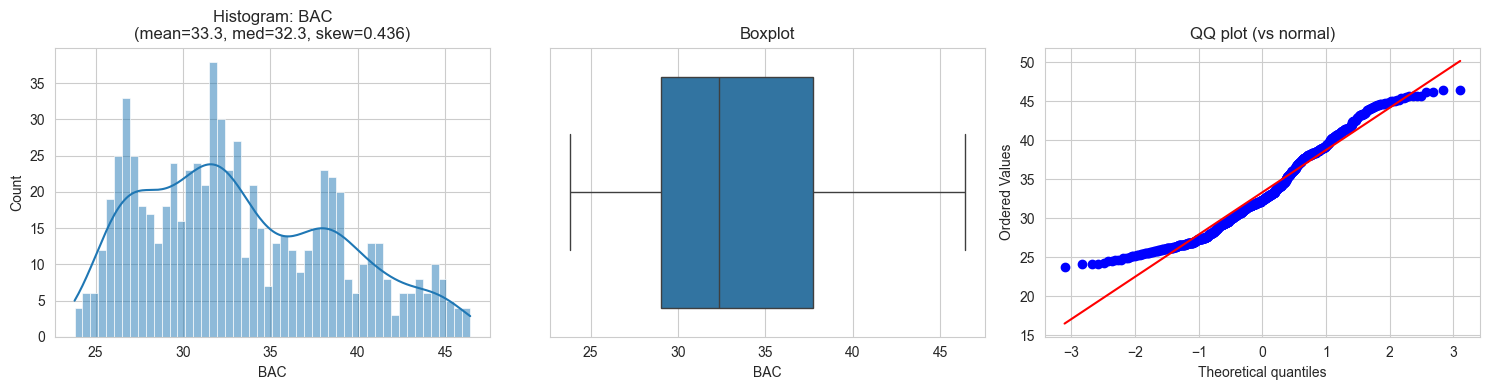

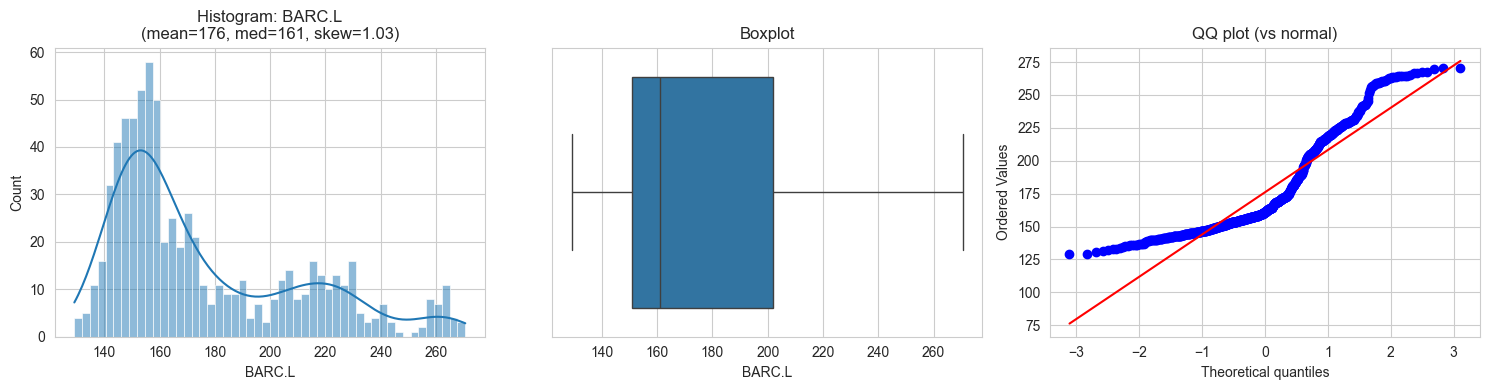

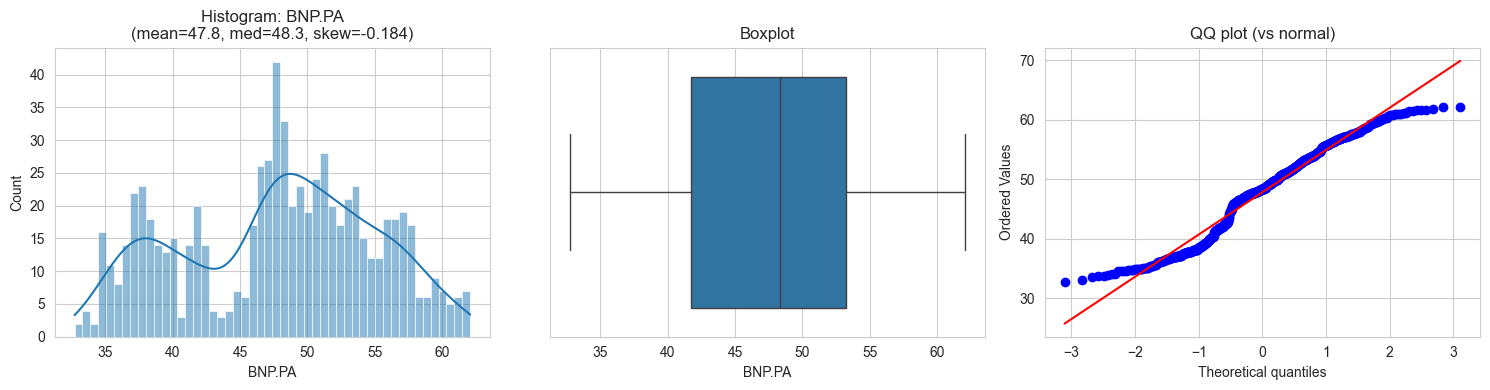

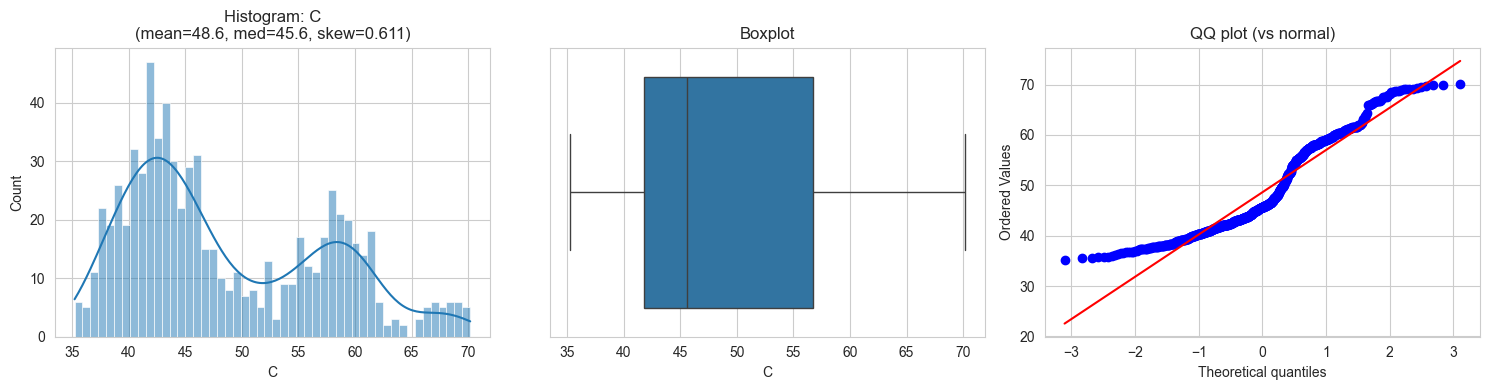

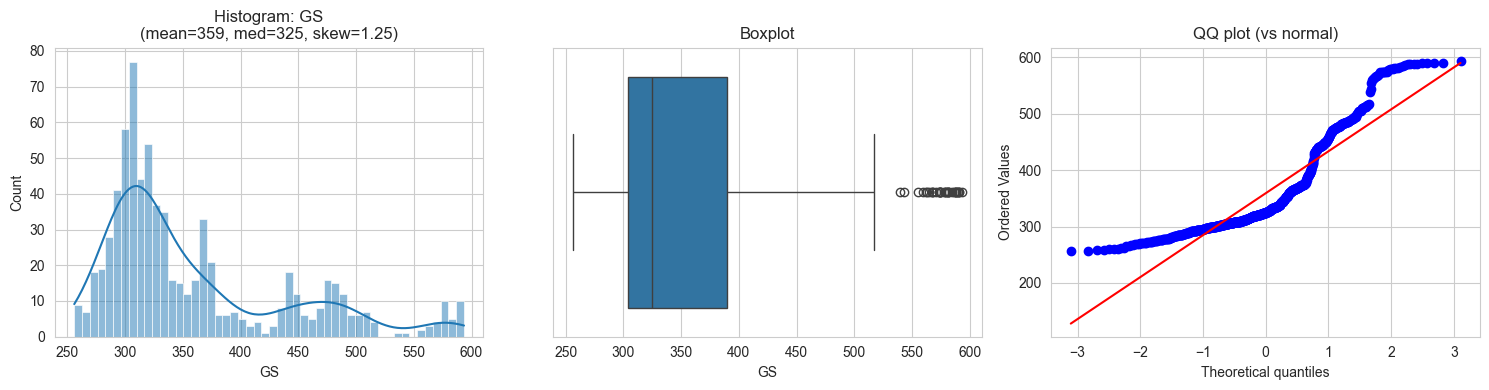

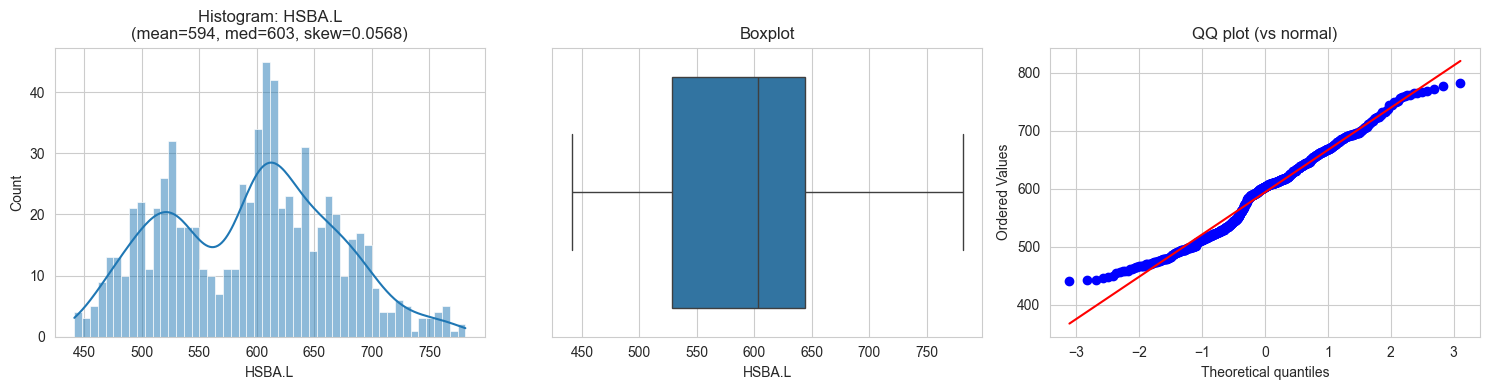

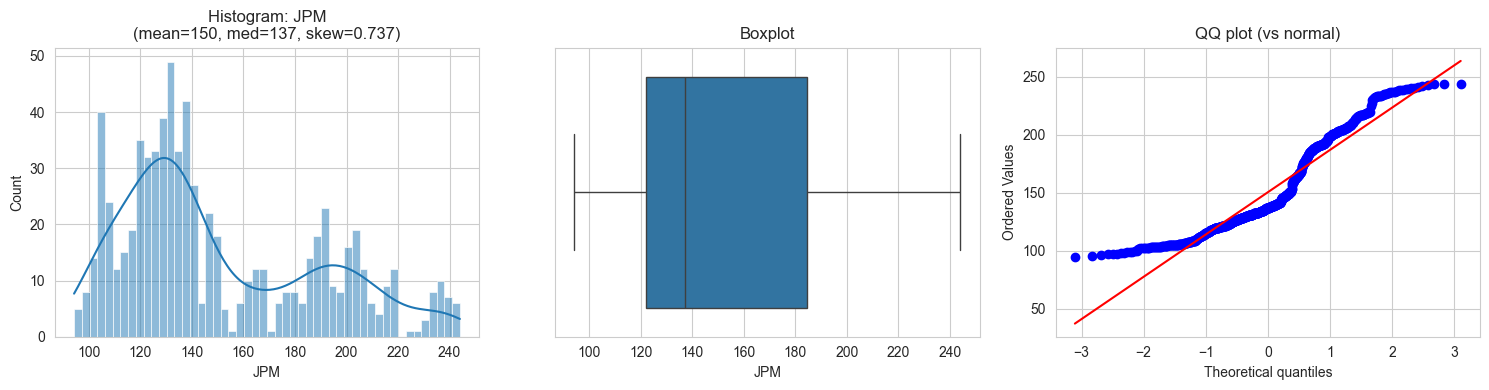

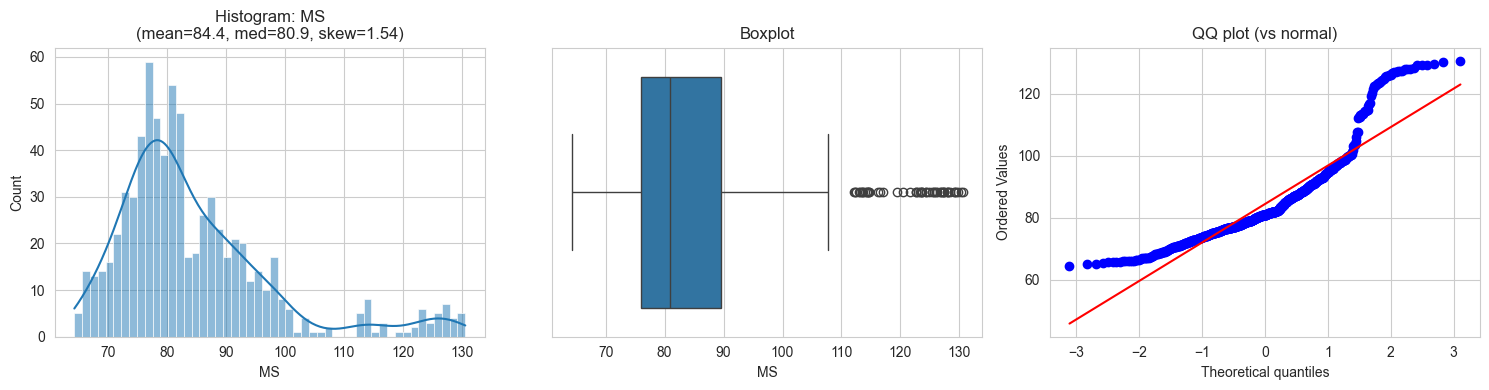

In [8]:
eda.plot_numeric_univariate(data["Adj Close"], cols=data["Adj Close"].columns.tolist(), bins=50)

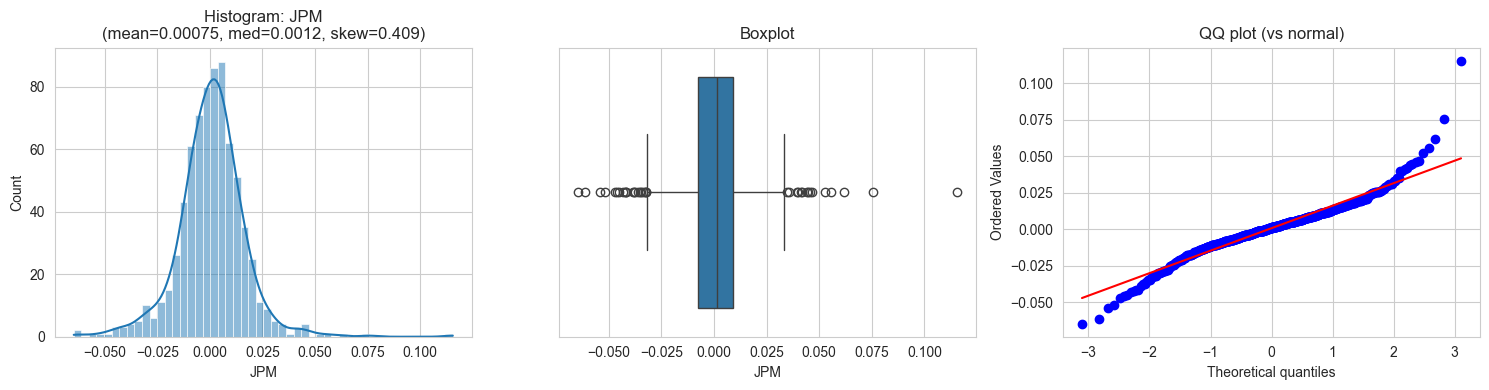

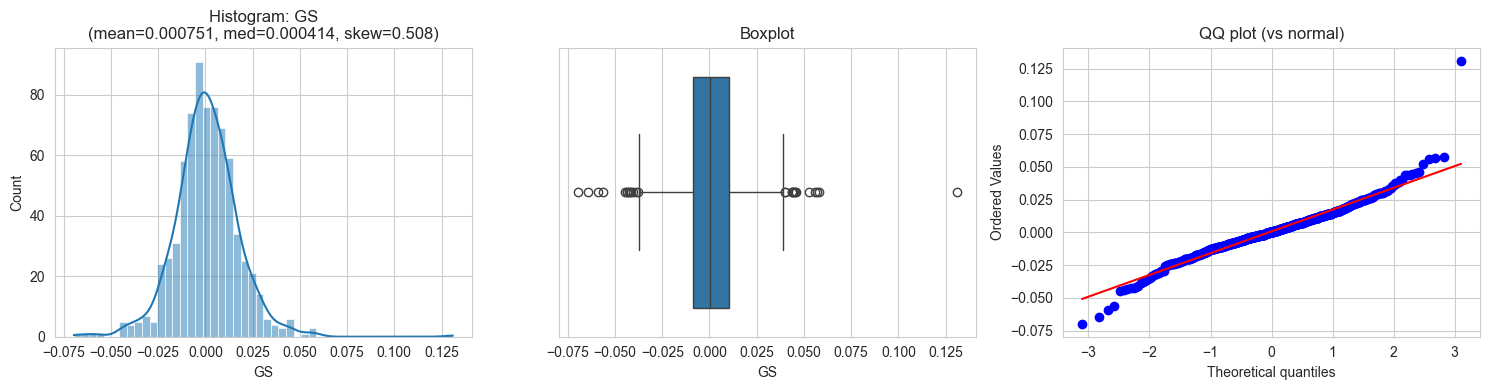

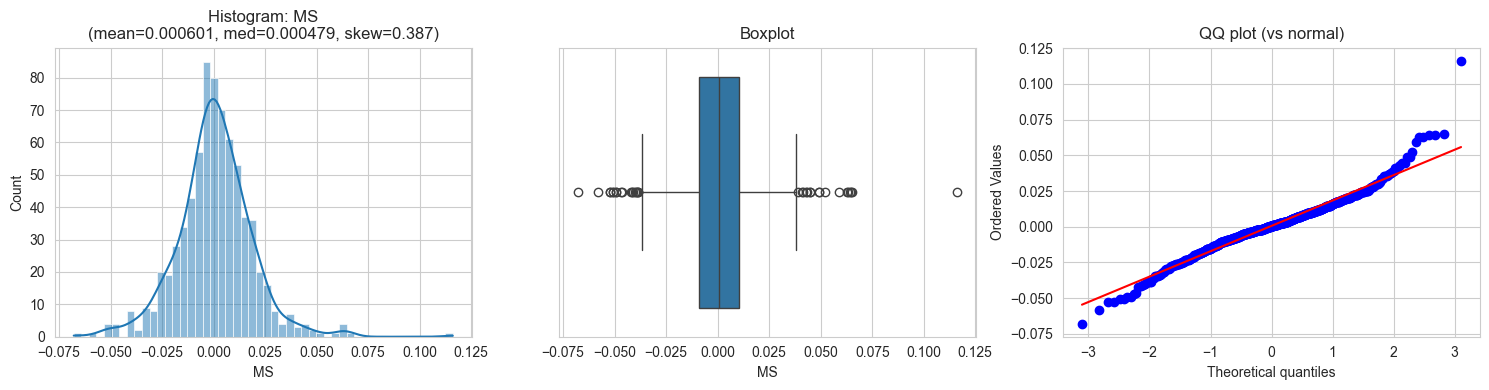

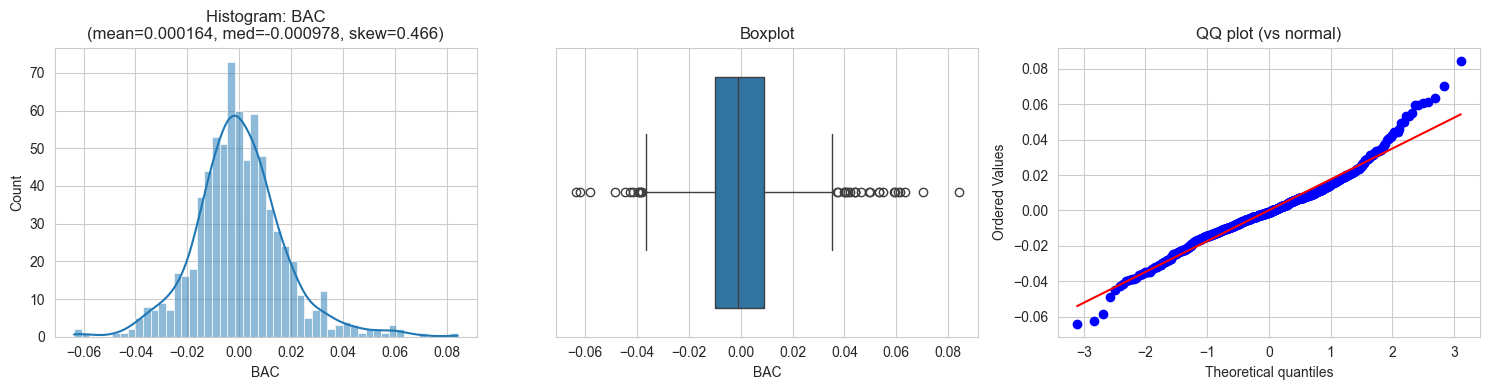

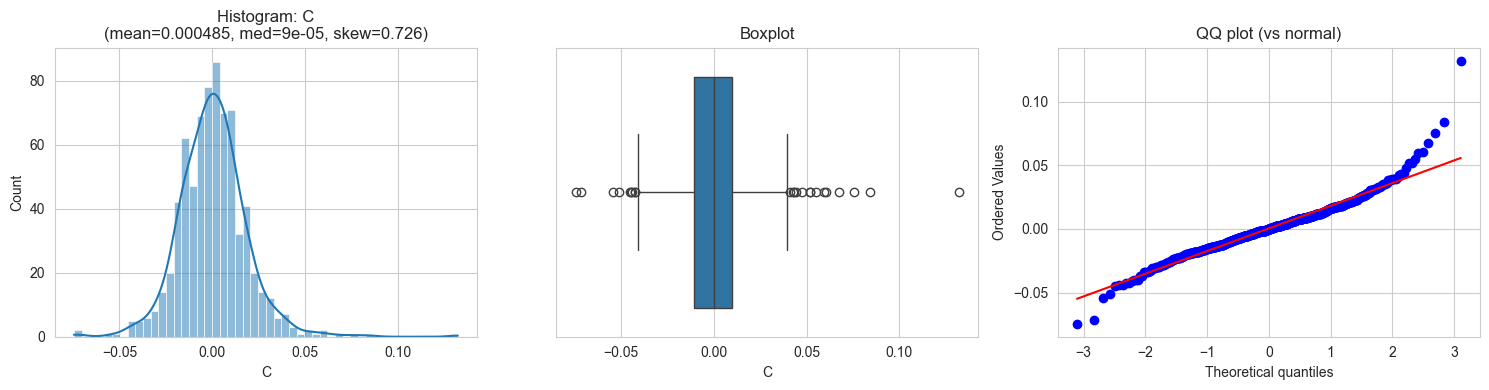

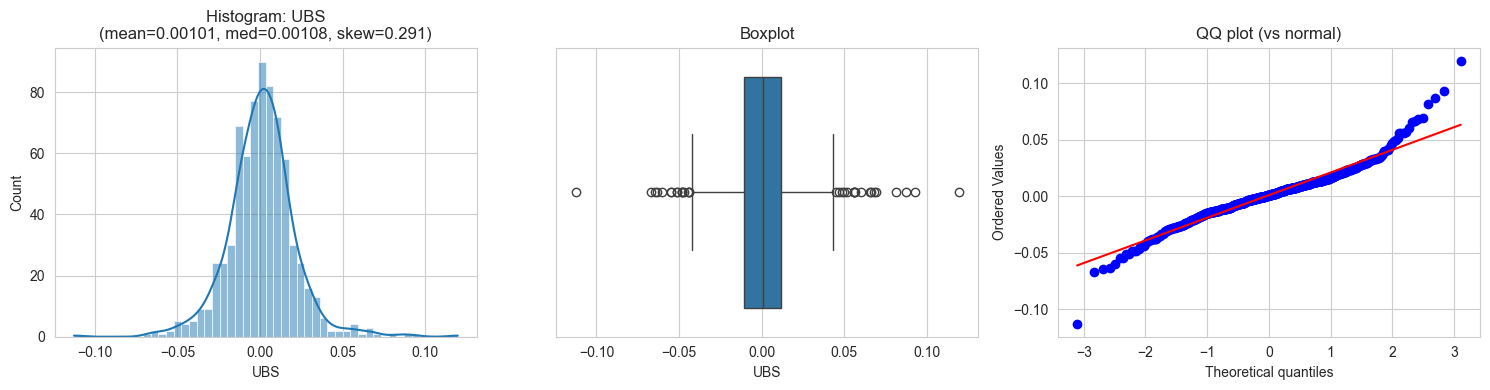

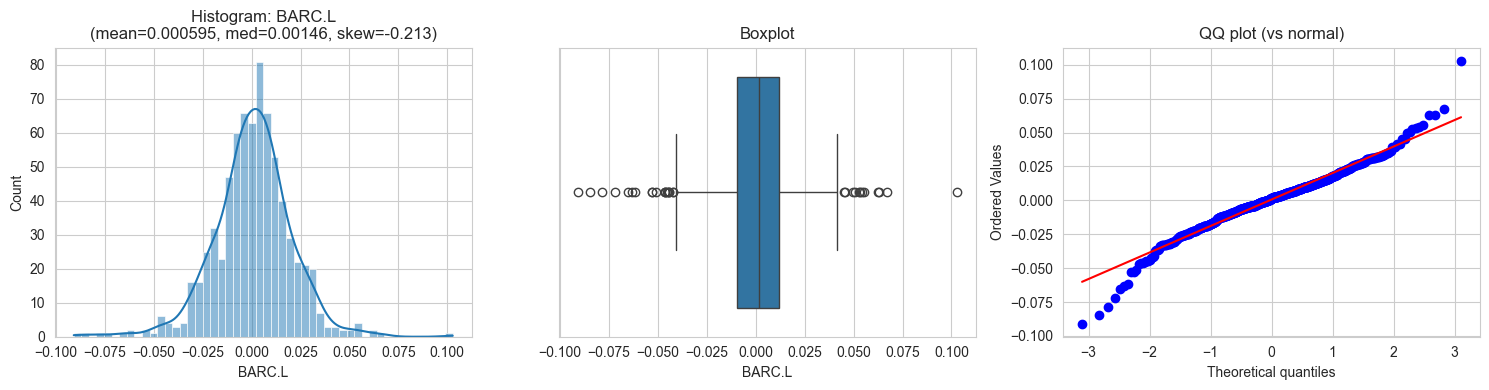

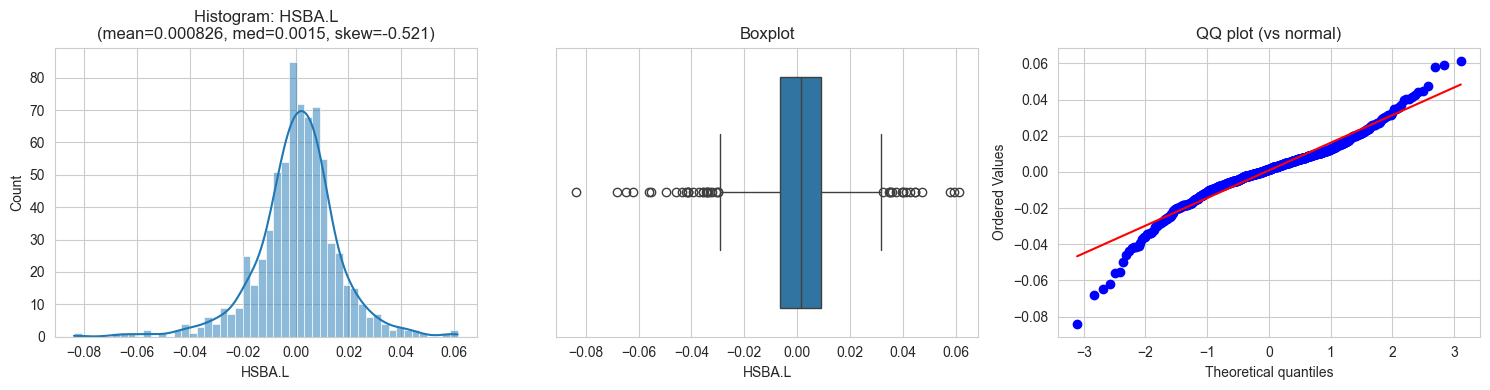

In [18]:
# For the strategy in mind later - will apply a data analysis of the returns
for ticker in tickers:
    data[("Returns", ticker)] = data["Adj Close"][ticker].pct_change()

data.dropna(inplace=True)

eda.plot_numeric_univariate(data["Returns"], cols=data["Returns"].columns.tolist(), bins=50)

Question - what to do with skewed data?


In [10]:
# Obtain outliers based on IQR method 

eda.detect_outliers_iqr(data["Log_Returns"], cols=data["Log_Returns"].columns.tolist())

n_outliers  pct_outliers
column                          
HSBA.L          44      6.002729
JPM             36      4.911323
BNP.PA          35      4.774898
MS              34      4.638472
BAC             33      4.502046
UBS             33      4.502046
BARC.L          31      4.229195
GS              27      3.683492
C               23      3.137790

Also from the boxplots, we note that GS and MS have significant outliers - we want to investigate these further.

<Axes: title={'center': 'MS Log Returns Time Series'}, xlabel='Date'>

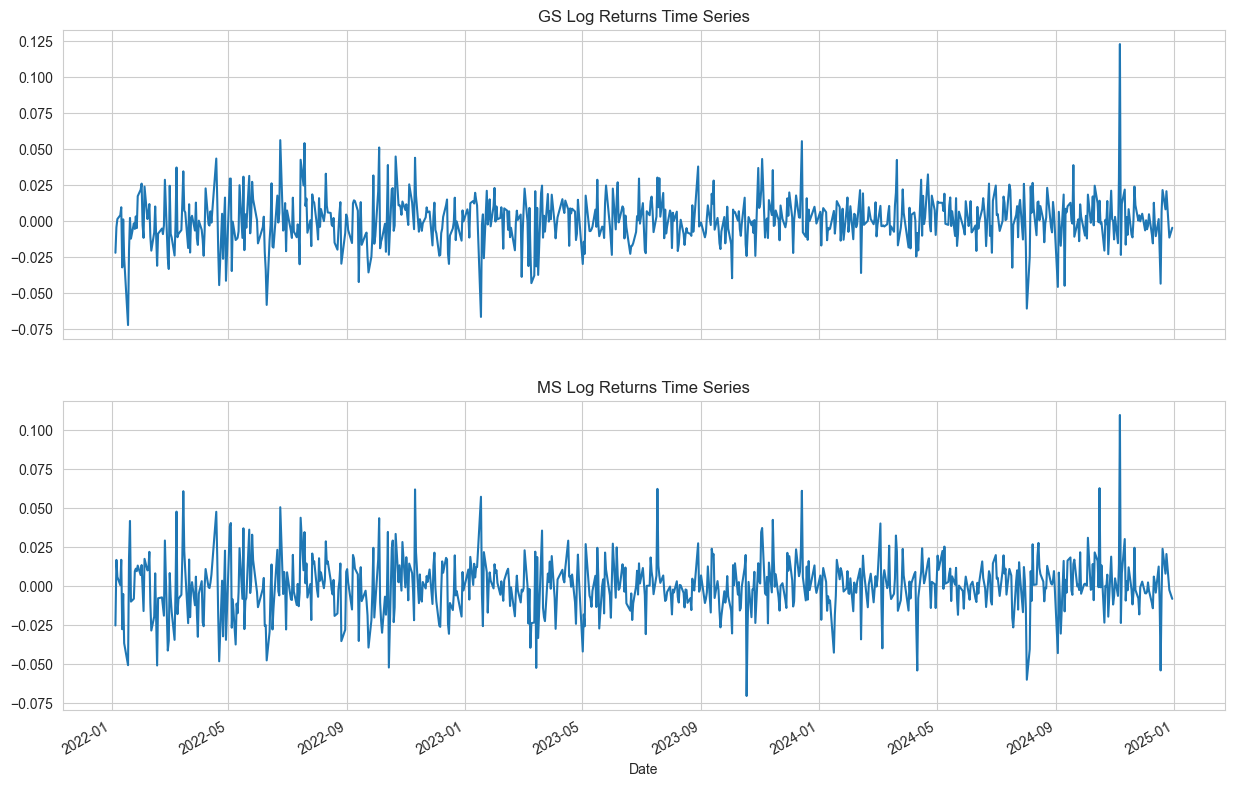

In [11]:
gs_return_series = data["Log_Returns"]["GS"]
ms_return_series = data["Log_Returns"]["MS"]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,10), sharex=True)
gs_return_series.plot(ax=ax[0], title='GS Log Returns Time Series')
ms_return_series.plot(ax=ax[1], title='MS Log Returns Time Series') 

It seems both days have the same spike in log returns on the same day - identify the date.

In [12]:
print("The day which log returns was unusually high for GS:", gs_return_series.index[np.argmax(gs_return_series)])
print("The day which log returns was unusually high for MS:", ms_return_series.index[np.argmax(ms_return_series)])


print("\n" + "=" * 30 + " Continuing for the other stocks " + "=" * 30)
jpmc_return_series = data["Log_Returns"]["JPM"]
bac_return_series = data["Log_Returns"]["BAC"]

print("The day which log returns was unusually high for JPMC:", jpmc_return_series.index[np.argmax(jpmc_return_series)])
print("The day which log returns was unusually high for BAC:", bac_return_series.index[np.argmax(bac_return_series)])

print("\n" + "=" * 30 + " Conclusion: " + "=" * 30)
print("Upon inspection the spike in log returns was becaused of the win in the presidential election by Trump on 6th November 2024. ")

The day which log returns was unusually high for GS: 2024-11-06 00:00:00
The day which log returns was unusually high for MS: 2024-11-06 00:00:00

============================== Continuing for the other stocks ==============================
The day which log returns was unusually high for JPMC: 2024-11-06 00:00:00
The day which log returns was unusually high for BAC: 2024-11-06 00:00:00

============================== Conclusion: ==============================
Upon inspection the spike in log returns was becaused of the win in the presidential election by Trump on 6th November 2024. 


# Returns EDA 

[*********************100%***********************]  9 of 9 completed


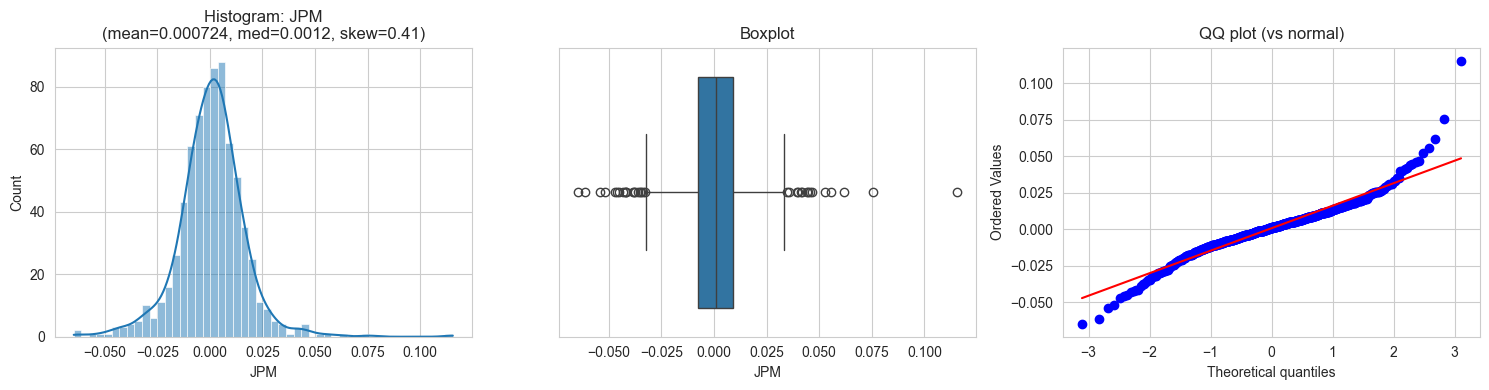

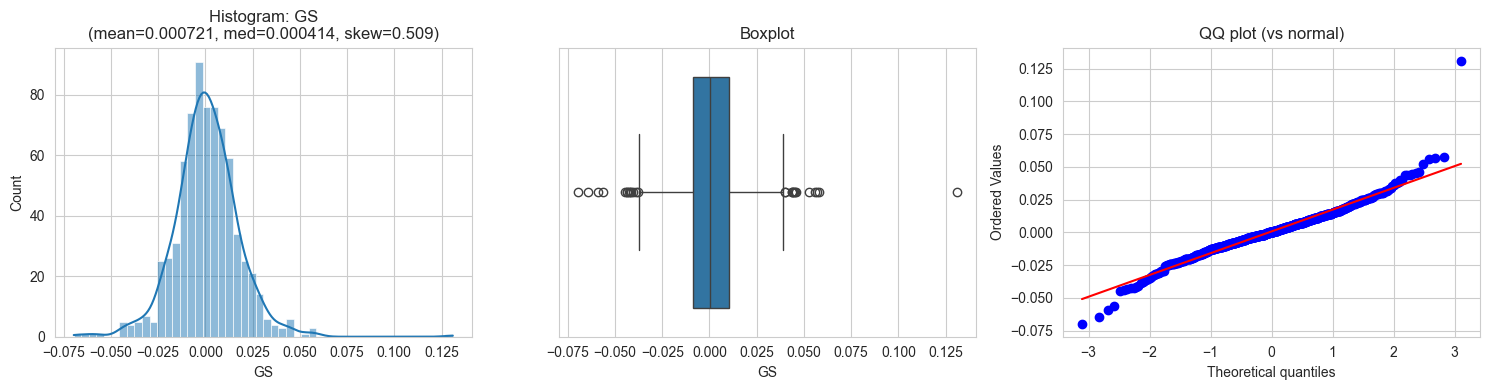

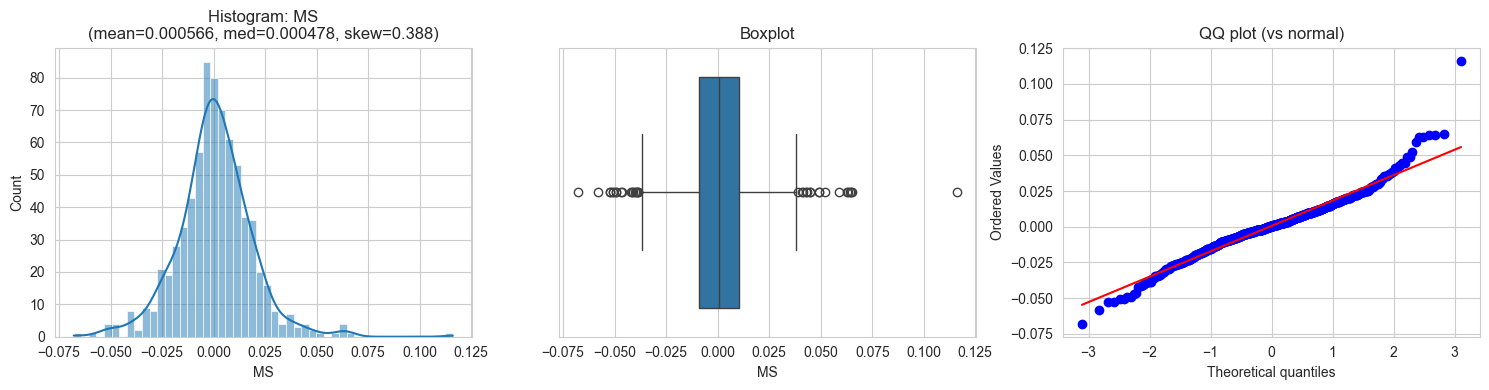

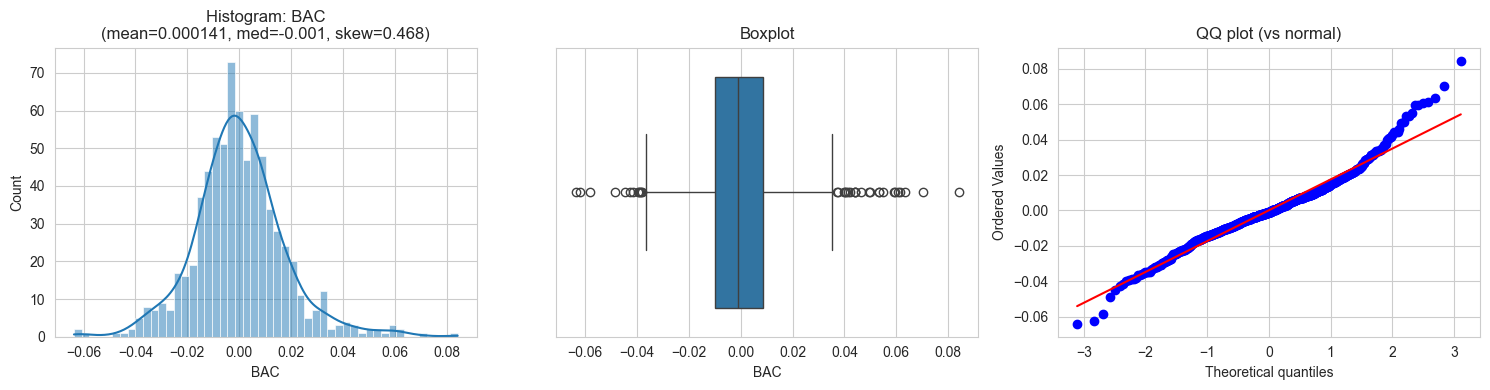

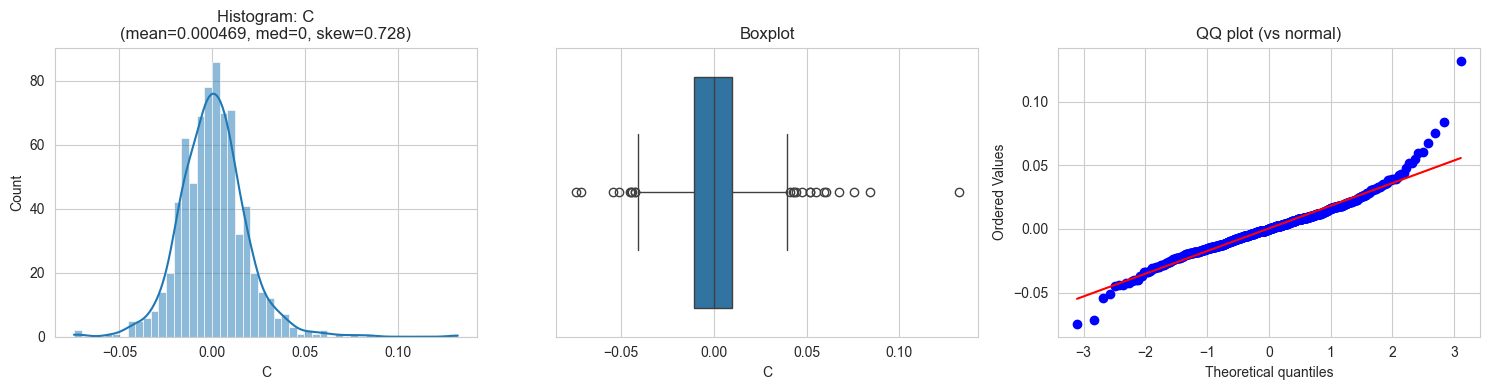

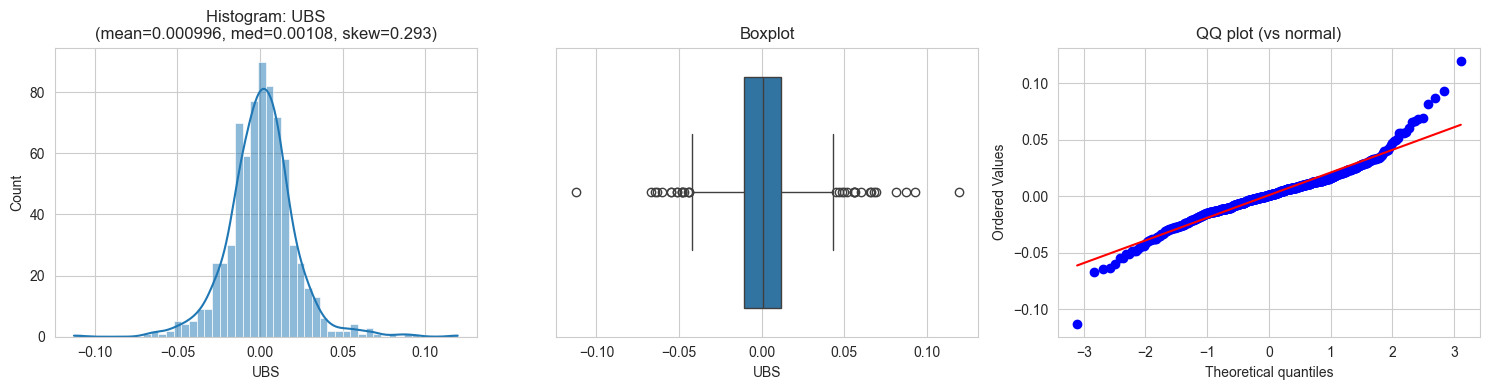

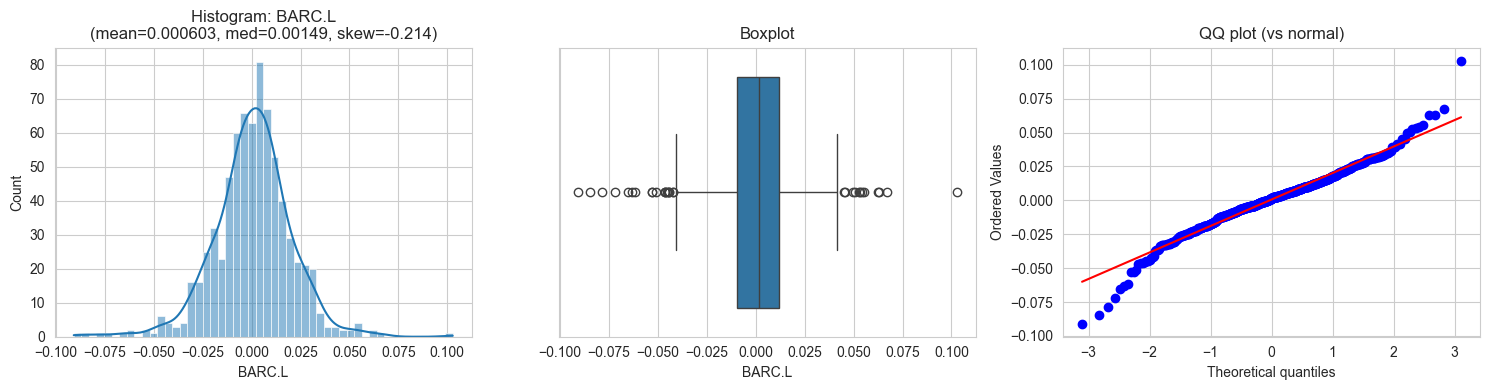

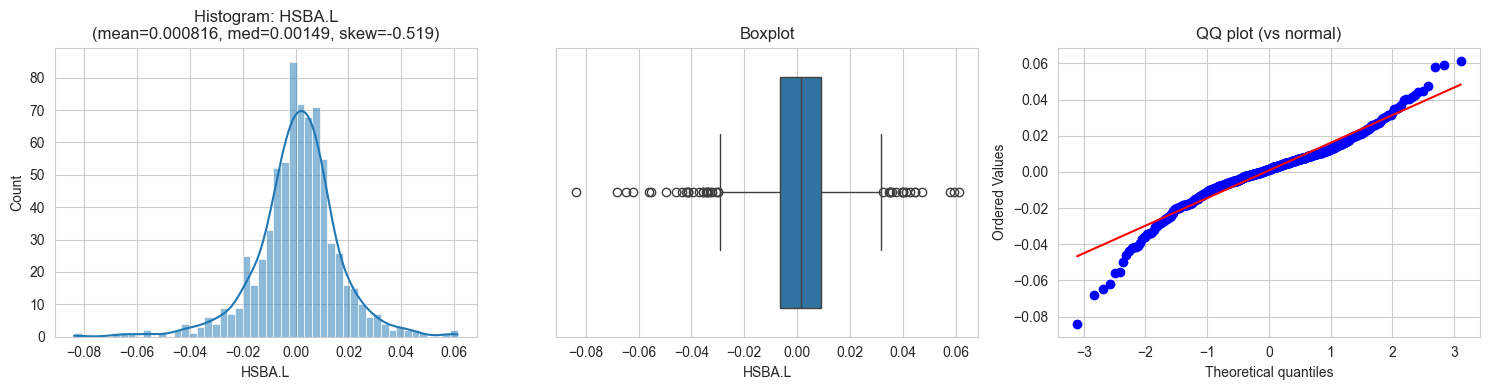

In [22]:
data = obtain_data().dropna()

eda.plot_numeric_univariate(data["Returns"], cols=data["Returns"].columns.tolist(), bins=50)

In [24]:
eda.detect_outliers_iqr(data["Returns"], cols=data["Returns"].columns.tolist())

n_outliers  pct_outliers
column                          
HSBA.L          43      5.866303
BAC             35      4.774898
MS              35      4.774898
JPM             34      4.638472
UBS             34      4.638472
BNP.PA          33      4.502046
BARC.L          31      4.229195
GS              26      3.547067
C               23      3.137790

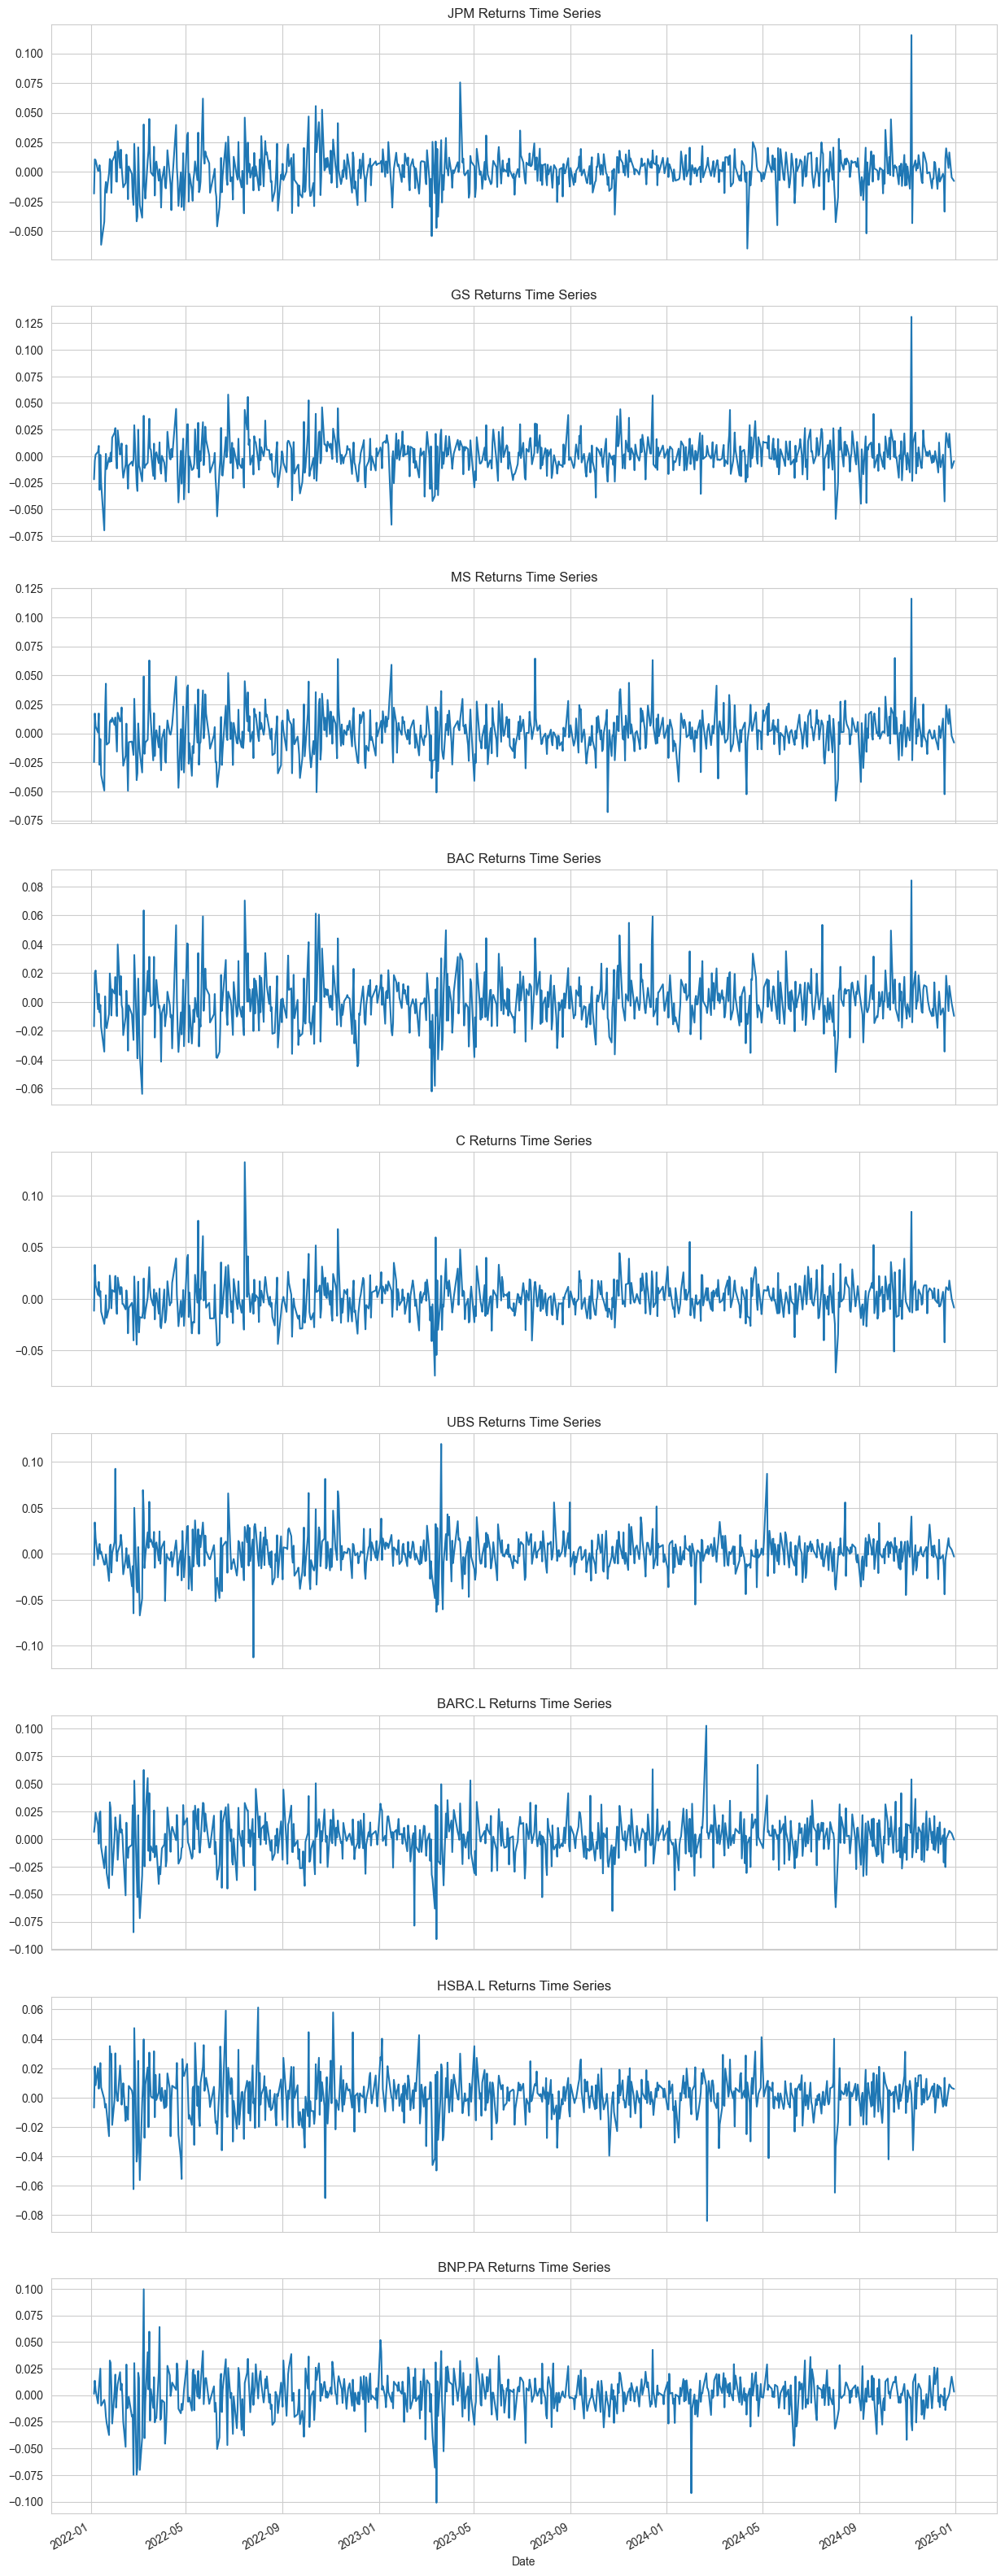

In [27]:
fig, ax = plt.subplots(nrows=len(data["Returns"].columns), ncols=1, figsize=(15, 5 * len(data["Returns"].columns)), sharex=True)
for i, col in enumerate(data["Returns"].columns):
    data["Returns"][col].plot(ax=ax[i], title=f'{col} Returns Time Series')

### Windsorisation

The idea is to now cap the outliers so that it does not affect linear regression too much 

[*********************100%***********************]  9 of 9 completed


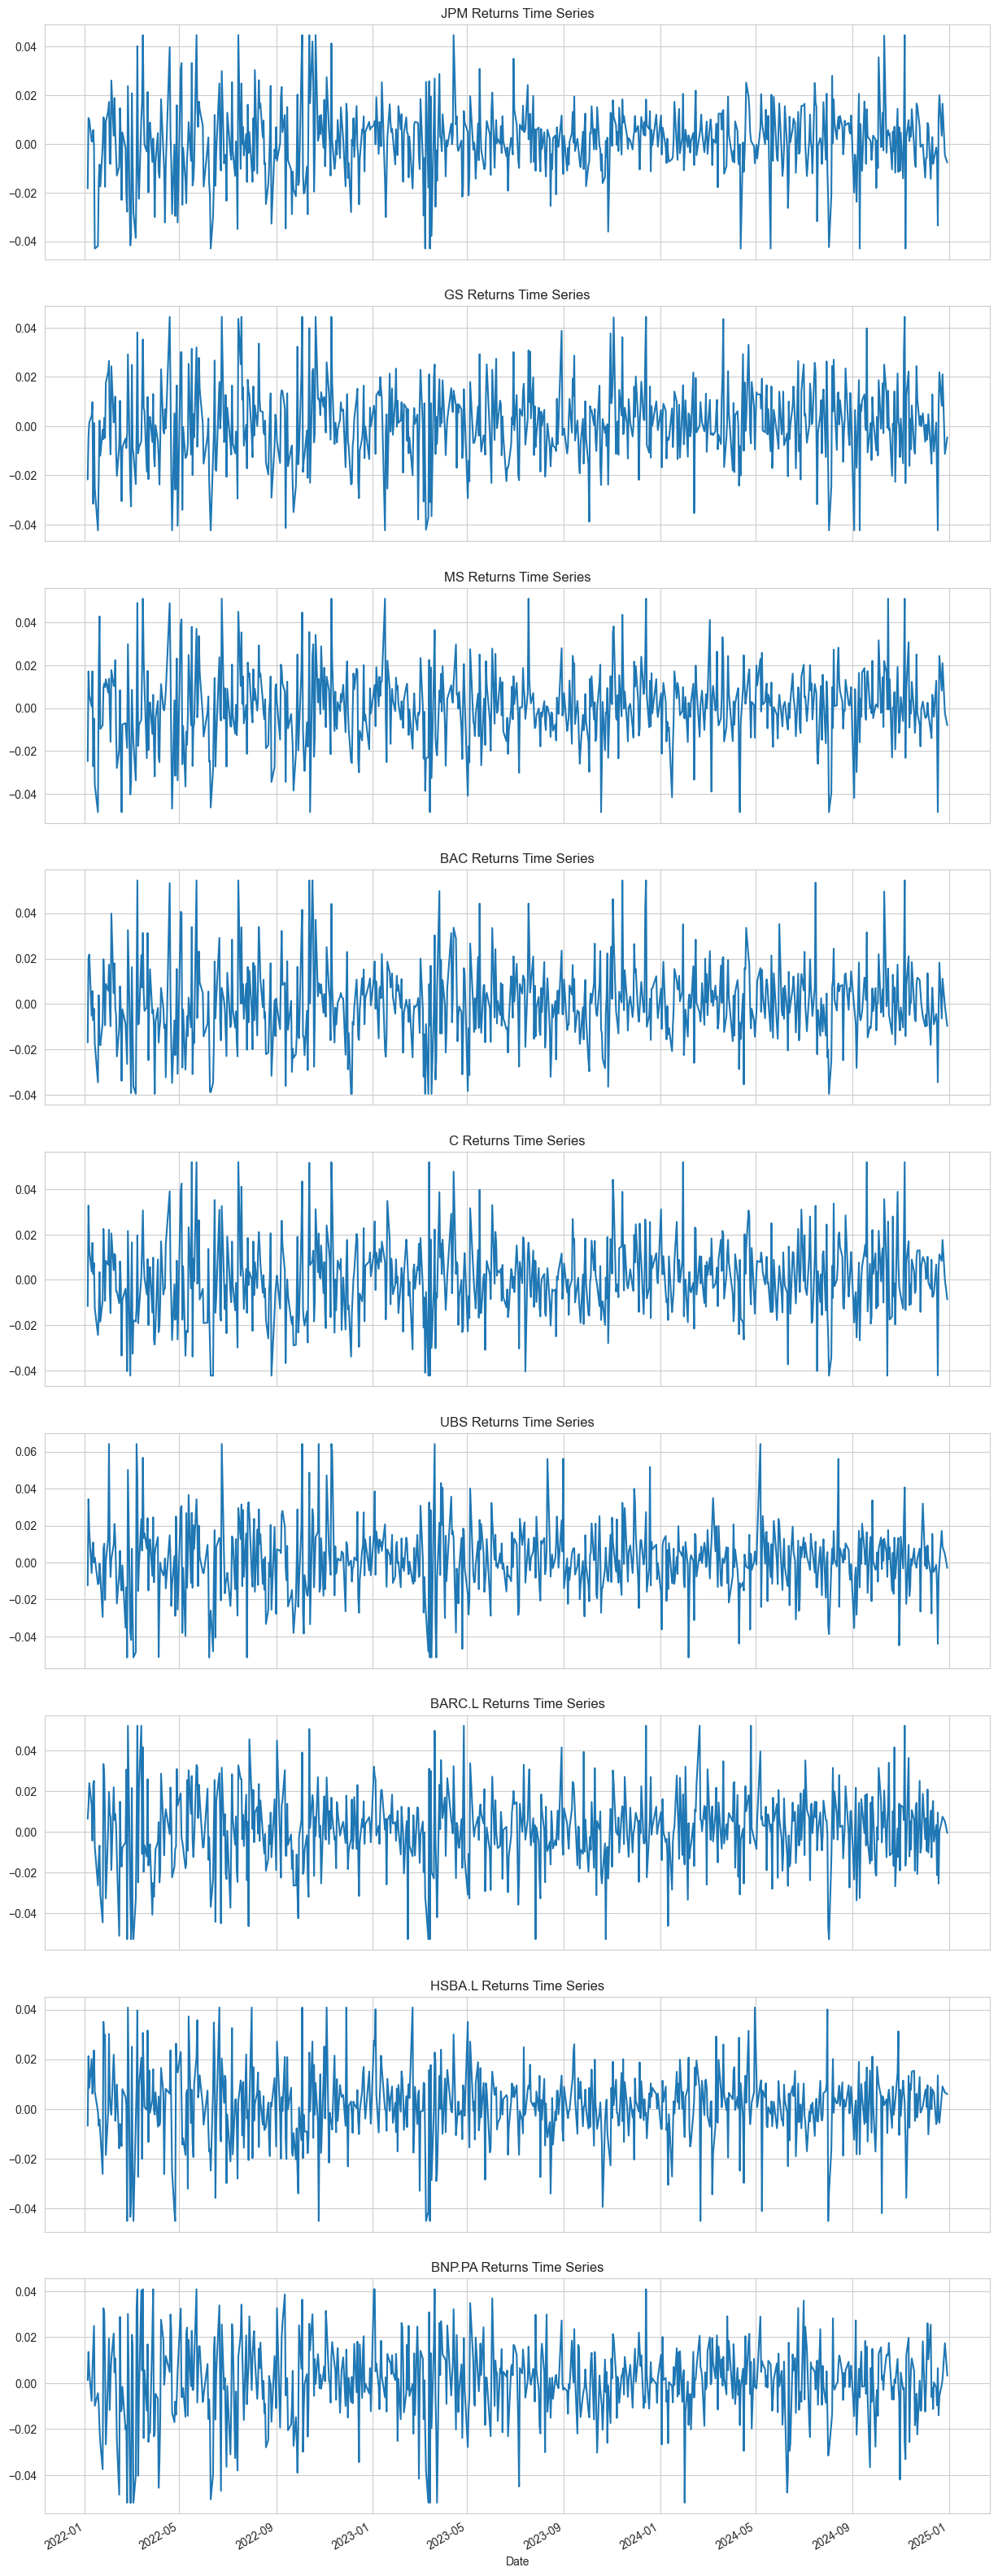

In [73]:
data = obtain_data().dropna()

data["Returns"] = data["Returns"].clip(lower=data["Returns"].quantile(0.01, axis=0), upper=data["Returns"].quantile(0.99, axis=0), axis=1)

fig, ax = plt.subplots(nrows=len(data["Returns"].columns), ncols=1, figsize=(15, 5 * len(data["Returns"].columns)), sharex=True)
for i, col in enumerate(data["Returns"].columns):
    data["Returns"][col].plot(ax=ax[i], title=f'{col} Returns Time Series')

# Volume EDA 

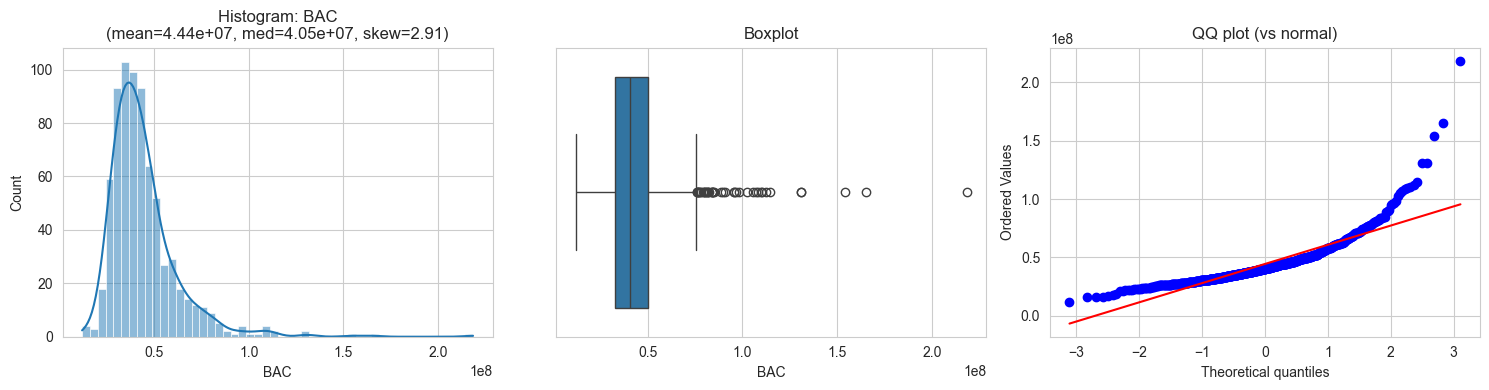

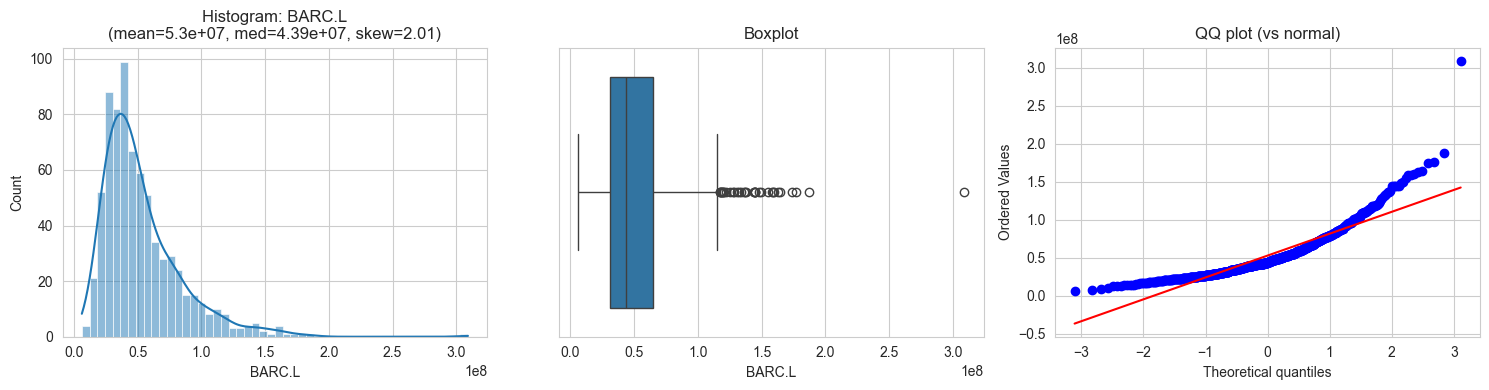

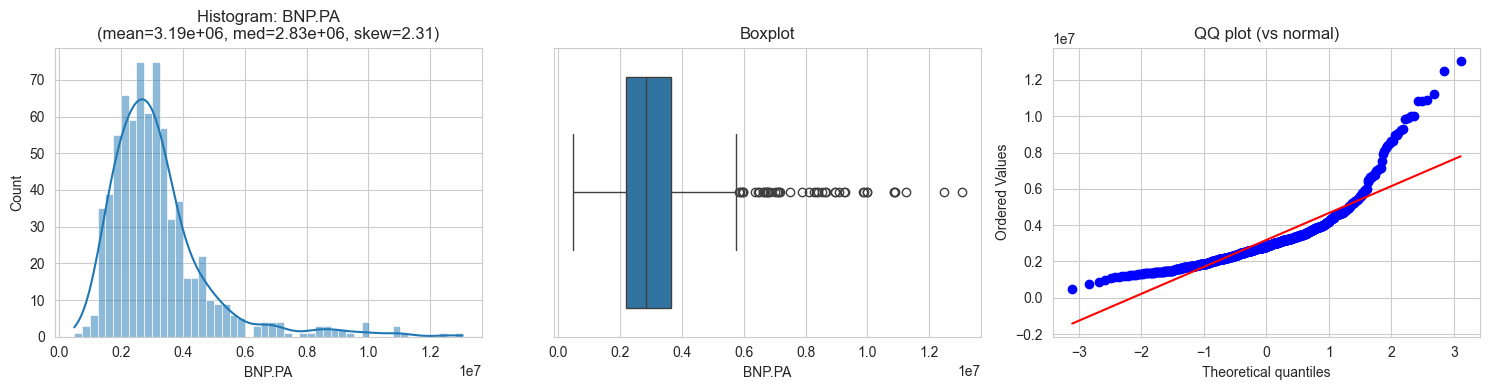

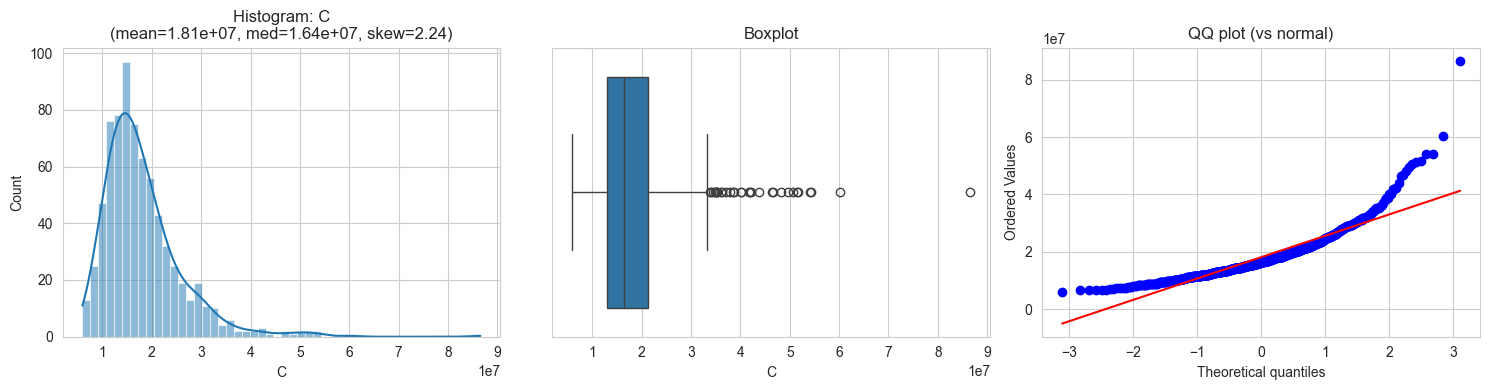

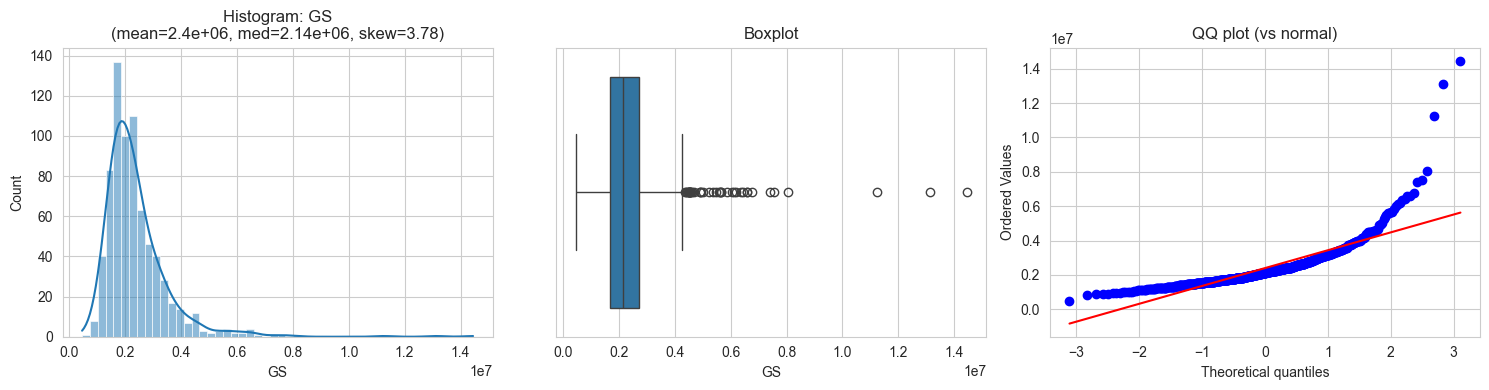

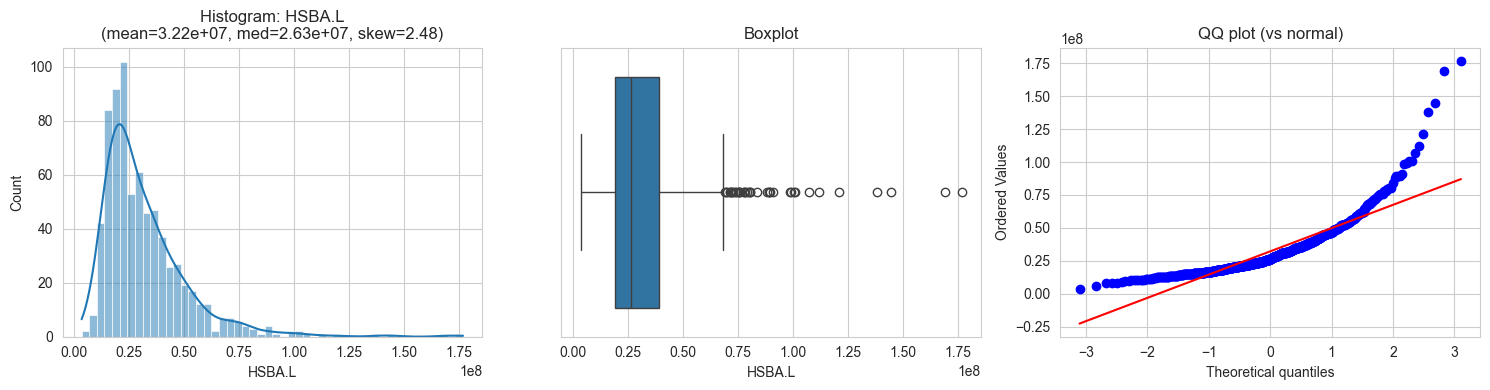

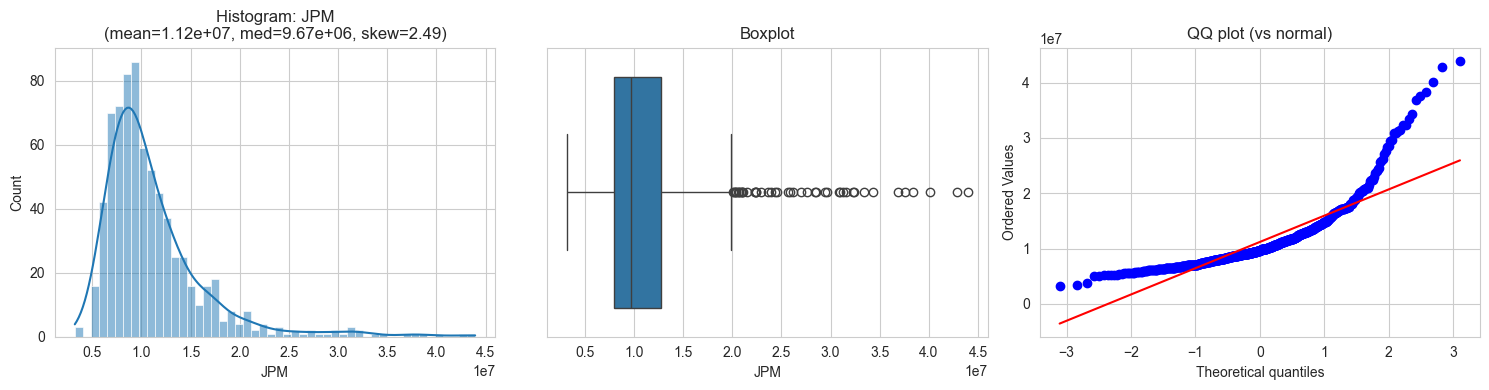

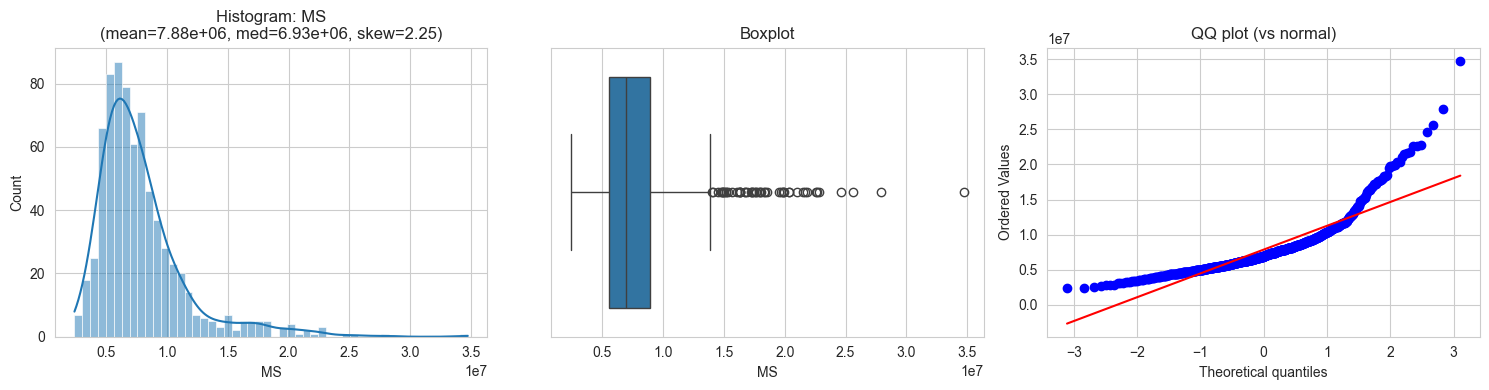

In [13]:
volume_data = data["Volume"]
eda.plot_numeric_univariate(volume_data, cols=volume_data.columns.tolist(), bins=50)

## Identificaton of Outlier Volume Trading Date 

In [14]:
ms_volume_series = data["Volume"]["MS"]
citi_volume_series = data["Volume"]["C"]

print("Volume was unusually high for MS on:", ms_volume_series.index[np.argmax(ms_volume_series)])
print("Volume was unusually high for C on:", citi_volume_series.index[np.argmax(citi_volume_series)])

Volume was unusually high for MS on: 2023-10-18 00:00:00
Volume was unusually high for C on: 2022-07-15 00:00:00


Both of these dates correspond to earnings publication dates for both these stocks, which explains the high volume. 

# Correlation Plots 

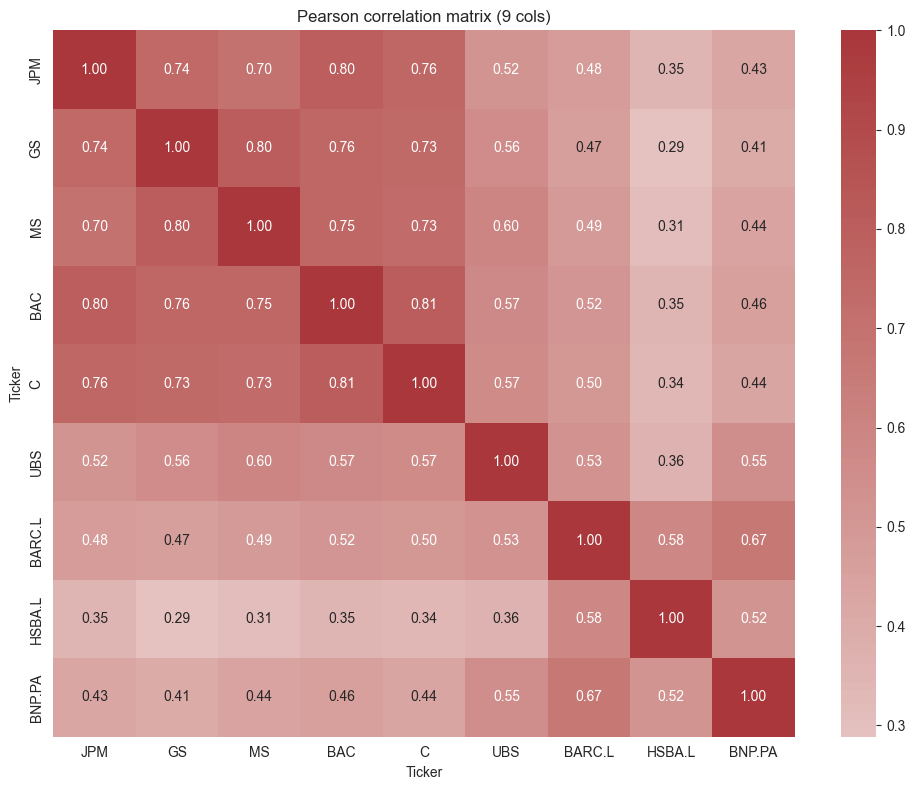

The minimum correlation is: 0.2885465194852154 and occurs between: GS and HSBA.L
The maximum correlation is: 0.8060817200964443 and occurs between: BAC and C


In [15]:
matrix = eda.correlation_matrix(data["Log_Returns"], cols=data["Log_Returns"].columns.tolist())
print("The minimum correlation is:", matrix.min().min(), "and occurs between:", data["Log_Returns"].columns[np.where(matrix == matrix.min().min())[0][0]], "and", data["Log_Returns"].columns[np.where(matrix == matrix.min().min())[1][0]])
print("The maximum correlation is:", matrix[matrix < 1].max().max(), "and occurs between:", data["Log_Returns"].columns[np.where(matrix == matrix[matrix < 1].max().max())[0][0]], "and", data["Log_Returns"].columns[np.where(matrix == matrix[matrix < 1].max().max())[1][0]])

Thoughts after EDA:
1. The correlation between American bank stocks are very high. Consider doing PCA to reduce dimensionality and run an GARCH on the principal components instead.

# <a> PCA  </a> 




In [16]:
tickers = [
    "JPM",   # JPMorgan (NYSE)
    "GS",    # Goldman Sachs (NYSE)
    "MS",    # Morgan Stanley (NYSE)
    "BAC",   # Bank of America (NYSE)
    "C",     # Citigroup (NYSE)
    "UBS",   # UBS (NYSE / SIX)
    "BARC.L",# Barclays (LSE)
    "HSBA.L",# HSBC (LSE)
    "BNP.PA" # BNP Paribas (Euronext Paris)
]


dates = (pd.Timestamp("2022-01-01"), pd.Timestamp("2024-12-31"))
interval = "1d"

data = yf.download(tickers, start=dates[0], end=dates[1], interval=interval, auto_adjust=False).dropna()
# Replace whitespace in the field level of the MultiIndex columns
data.columns = data.columns.set_levels(
    data.columns.levels[0].str.replace(" ", "_"),
    level=0,
    verify_integrity=False,
 )
#data.columns = [f"{ticker}_{col}" for col, ticker in data.columns]

data = data.dropna()
for ticker in tickers:
    data[("Log_Returns", ticker)] = np.log(data["Adj_Close"][ticker]).diff()

[*********************100%***********************]  9 of 9 completed


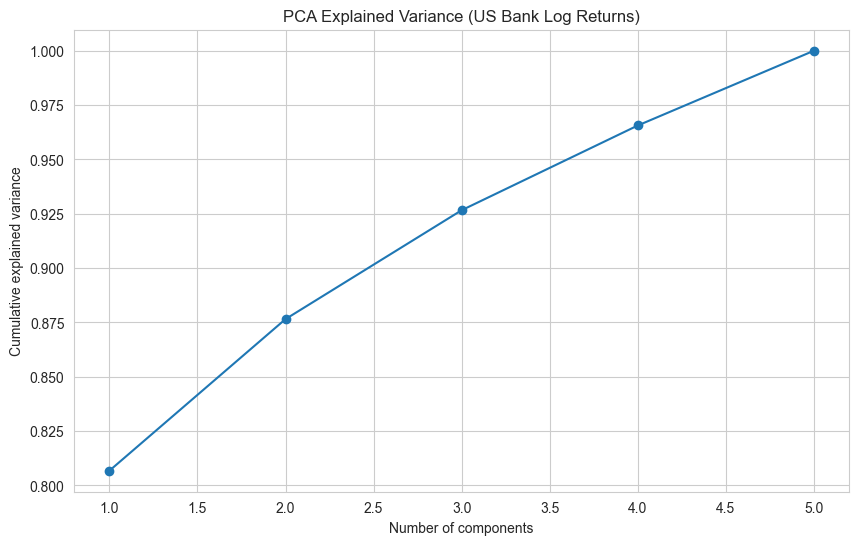

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

log_returns = data["Log_Returns"].dropna()
us_tickers = ["JPM", "GS", "MS", "BAC", "C"]
log_returns_american = log_returns[us_tickers]
X_scaled = StandardScaler().fit_transform(log_returns_american)

pca = PCA()
pca.fit(X_scaled)

explained = pca.explained_variance_ratio_
cumulative = explained.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative) + 1), cumulative, marker="o")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Explained Variance (US Bank Log Returns)")
plt.grid(True)
plt.show()

After conducting PCA, it takes 3 components to explain 90% of the variance in the data. This is possibly because the correlations between the bank stocks are not that close to collinearity. Since the results become less interpretable, PCA is not pursued further. 

# Feature Engineering - Momentum for Next Day Returns 


[*********************100%***********************]  9 of 9 completed


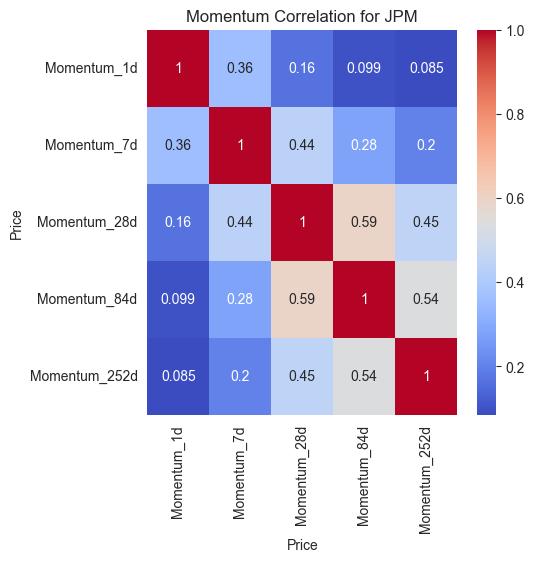

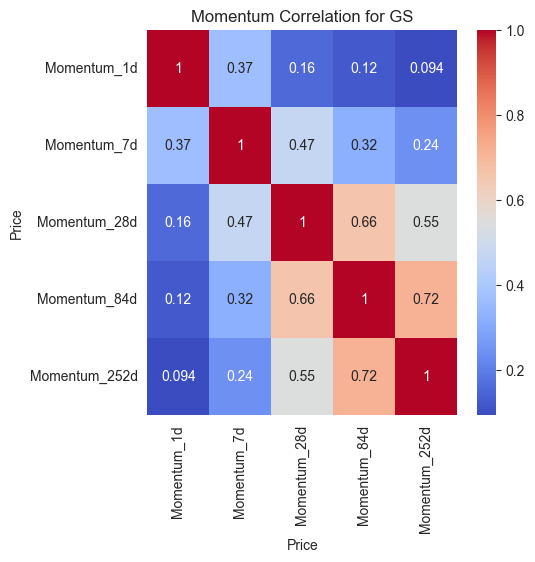

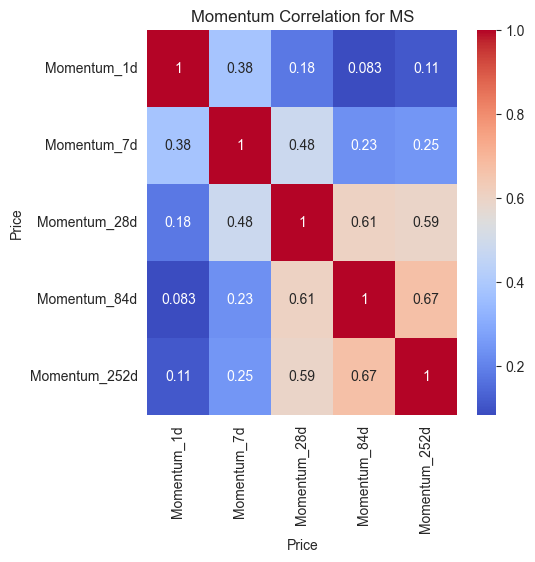

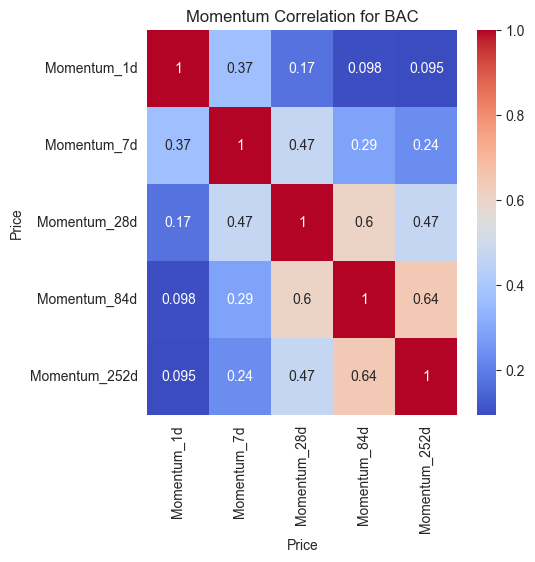

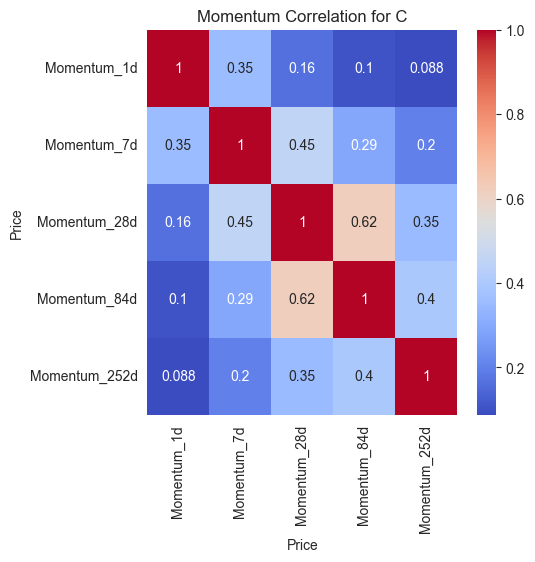

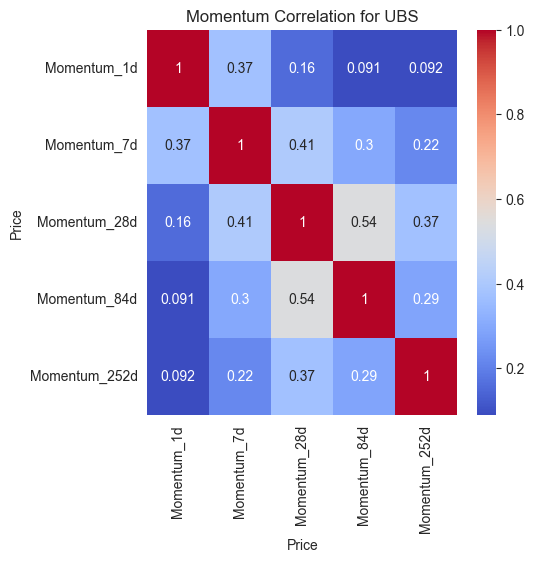

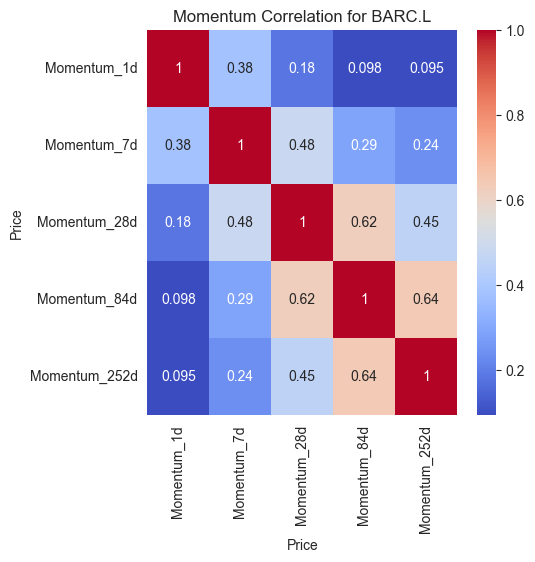

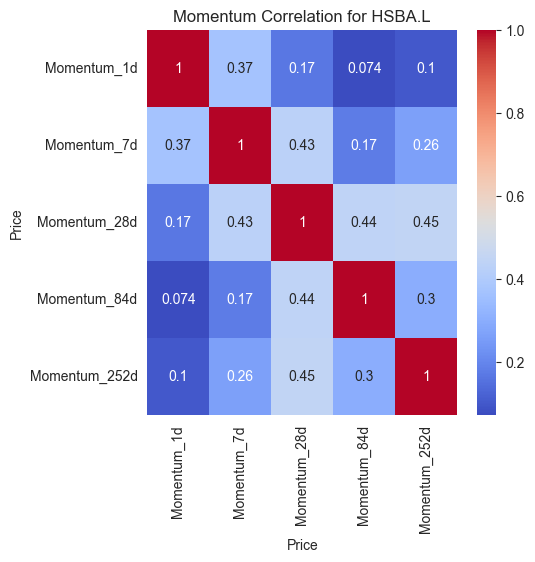

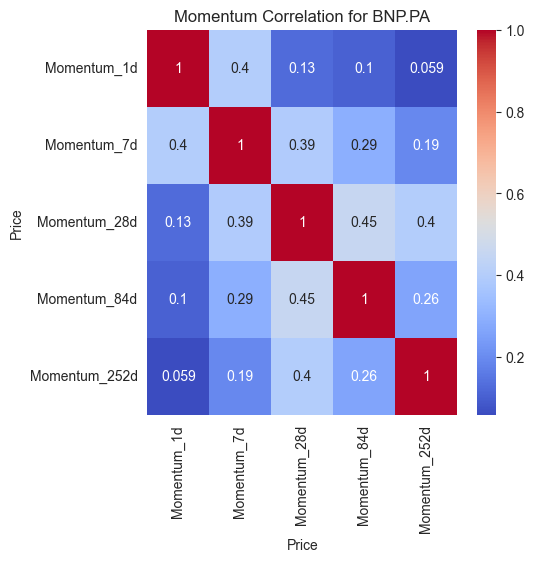

In [18]:
# Quick EDA of correlations for momentum to ensure no multicollinearity issues

data = obtain_data().dropna()
# Daily, weekly, monthly, quarterly, yearly momentum
momentum_days = [1, 7, 28, 84, 252]

for ticker in tickers:
    for days in momentum_days:
        data[(f"Momentum_{days}d", f"{ticker}")] = data["Adj_Close"][ticker] - data["Adj_Close"][ticker].shift(days)
data.dropna(inplace=True)


for ticker in tickers:
    df = data.xs(ticker, level=1, axis=1)
    momentum_column_names = [f"Momentum_{d}d" for d in momentum_days]
    momentum_columns = df[momentum_column_names]
    
    plt.figure(figsize=(5,5))
    sns.heatmap(momentum_columns.corr(), annot=True, cmap="coolwarm")
    plt.title(f"Momentum Correlation for {ticker}")
    plt.show()    

First attempt - calculate momentum features for each stock and run a regression to predict next day returns.

Second attempt - adding in a value factor - 

In [20]:
data = obtain_data()
tickers = [
        "JPM",   # JPMorgan (NYSE)
        "GS",    # Goldman Sachs (NYSE)
        "MS",    # Morgan Stanley (NYSE)
        "BAC",   # Bank of America (NYSE)
        "C",     # Citigroup (NYSE)
        "UBS",   # UBS (NYSE / SIX)
        "BARC.L",# Barclays (LSE)
        "HSBA.L",# HSBC (LSE)
        "BNP.PA" # BNP Paribas (Euronext Paris)
    ]
log_returns_df = data["Log_Returns"]

# I want to use multiple day momentum as features for next day returns prediction
momentum_days = [1, 7, 28, 84, 252]

for days in momentum_days:
    for ticker in tickers:
        data[(f"Momentum_{days}d", f"{ticker}")] = data["Adj_Close"][ticker] - data["Adj_Close"][ticker].shift(days)

data.dropna(inplace=True)

# Now I need to run a parallelised linear regression of next day returns against these momentum features
from sklearn.model_selection import GridSearchCV
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import Lasso
from joblib import Parallel, delayed
import pandas as pd

def _fit_ticker_regression(ticker: str) -> dict:
    feature_cols = [(f"Momentum_{d}d", ticker) for d in momentum_days]
    X = data.loc[:, feature_cols]
    X.columns = [f"Momentum_{d}d" for d in momentum_days]

    # Standard scaling 
    ss_x, ss_y = StandardScaler(), StandardScaler()
    # working around the return types of StandardScaler
    X_vals = ss_x.fit_transform(X)
    X_df = pd.DataFrame(X_vals, columns=ss_x.feature_names_in_)
    y_vals = ss_y.fit_transform(log_returns_df[ticker].shift(-1).dropna().values.reshape(-1, 1))
    y_df = pd.DataFrame(y_vals, columns=["y"])
    # Merging the dataframes together 
    df = pd.concat([X_df, y_df], axis=1).dropna()
    # Error handling 
    if df.empty:
        return {"ticker": ticker, "nobs": 0, "r2": float("nan"), "intercept": float("nan"), **{c: float("nan") for c in X.columns}}
    
    #X_const = sm.add_constant(df[X.columns])
    #model = OLS(df["y"], X_const)

    model = Lasso(fit_intercept=True)
    grid_search = GridSearchCV(model, param_grid={"alpha": [0.01, 0.1, 1.0, 10.0]}, cv=5, scoring="neg_mean_squared_error")
    grid_search.fit(df[X.columns], df["y"])
    model = grid_search.best_estimator_
    #res = model.fit()
    res = model.fit(df[X.columns], df["y"])
    return {
        "ticker": ticker,
        "cv_score": grid_search.best_score_,
        "nobs": int(len(df)),
        #"r2": float(res.rsquared),
        "intercept": float(res.intercept_),
        "Lasso_alpha": float(model.alpha),
        **{name: float(coef) for name, coef in zip(X.columns, res.coef_)},
    }

results = Parallel(n_jobs=-1, prefer="threads")(delayed(_fit_ticker_regression)(ticker) for ticker in tickers)
regression_results = pd.DataFrame(results).set_index(["ticker"])
regression_results.sort_index(inplace=True)
regression_results



[*********************100%***********************]  9 of 9 completed


cv_score  nobs  intercept  Lasso_alpha  Momentum_1d  Momentum_7d  \
ticker                                                                     
BAC    -1.172828   482  -0.037208         0.01     0.045905     0.007579   
BARC.L -1.096828   482  -0.047702         0.10     0.000000     0.000000   
BNP.PA -1.183062   482   0.005267         1.00    -0.000000    -0.000000   
C      -1.081662   482  -0.034430         0.01     0.049686     0.000000   
GS     -1.046561   482  -0.036483         0.01     0.067823     0.009461   
HSBA.L -1.112573   482  -0.007913         1.00    -0.000000    -0.000000   
JPM    -1.061156   482  -0.030926         0.01     0.092217     0.000000   
MS     -1.085732   482  -0.029537         1.00     0.000000     0.000000   
UBS    -1.206819   482   0.016478         1.00     0.000000     0.000000   

        Momentum_28d  Momentum_84d  Momentum_252d  
ticker                                             
BAC        -0.000000      0.000000       0.094372  
BARC.L      0.000000     -0.000000       0.000000  
BNP.PA     -0.000000     -0.000000       0.000000  
C           0.043537     -0.008883       0.071274  
GS          0.026096     -0.054488       0.099896  
HSBA.L      0.000000     -0.000000       0.000000  
JPM        -0.027150     -0.049797       0.146683  
MS          0.000000      0.000000       0.000000  
UBS        -0.000000     -0.000000       0.000000

Under linear regression, momentum by themselves do not seem to explain the next day returns well. Will try the multi-factor models as proposed by Fama and French next.

In [ ]:
import yfinance as yf

ticker = yf.Ticker("AAPL")
info = ticker.info

# Common value metrics available in .info
trailing_pe = info.get("trailingPE")
forward_pe = info.get("forwardPE")
pb_ratio = info.get("priceToBook")
ps_ratio = info.get("priceToSalesTrailing12Months")

pb_ratio

45.993664

# Implementing Random Strat

In [1]:
import sys 
sys.path.append(r"C:\\Users\\trund\\QRT")
from backtest.backtesting import Strategy, Trade
import backtest.backtest_results as btr
from typing import Callable, Optional, List, Dict, Any, Union, Tuple, Sequence

from abc import ABC, abstractmethod
from dataclasses import dataclass, field, asdict
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression


class FMMeanVariance(Strategy):

    # Generate docstring here later 
    def __init__(self,
                tradable_assets: List[str], 
                data: pd.DataFrame, # the data that the strategy operates on
                allow_short=True,
                cash_start: float = 100_000.0,
                commission: float = 0.0,  
                slippage: float = 0.0, 
                execute_on_next_tick: bool = True,
                rolling_window: int = 3, 
                target_ret: float = 0.01,
                rebalance_frequency: int = 7
                ):
        
        super().__init__(tradable_assets, data, allow_short, cash_start, commission, slippage, execute_on_next_tick)
        # Rolling window for the Fama-Macbeth regression
        self.rolling_window = rolling_window
        self.target_ret = target_ret
        self.weight_history = pd.DataFrame(index=data.index, columns=tradable_assets)

        # Rebalance frequency 
        self.rebalance_frequency = rebalance_frequency # Rebalance every 7 days (weekly)
    
    
    # Calculate the expected returns vector 
    def _calculate_returns(self, index):
        # Check if we have enough data for rolling window
        if index < self.rolling_window:
            # Not enough data, return equal signal
            return pd.Series(0.0, index=self.tradable_assets)

        # Assuming the y variable in the regression is returns.
        log_returns_ticker = [f"{ticker}_Log_Returns" for ticker in tradable_assets]
        rolling_mean = self.data[log_returns_ticker].iloc[index - self.rolling_window:index].mean()

        # Standardize with epsilon to avoid division by zero
        epsilon = 1e-8
        mean_val = rolling_mean.mean()
        std_val = rolling_mean.std()
        z_past = ((rolling_mean - mean_val) / (std_val + epsilon)).values.reshape(-1, 1)
        y_past = self.data[self.tradable_assets].iloc[index].values

        model = LinearRegression(fit_intercept=True).fit(z_past, y_past)    

        # Get the predictions for the next day 
        x_now = self.data[self.tradable_assets].iloc[index].values
        mean_now = x_now.mean()
        std_now = x_now.std()
        z_now = ((x_now - mean_now) / (std_now + epsilon)).reshape(-1, 1)
        signal = model.predict(z_now)

        return pd.Series(signal.flatten(), index=self.tradable_assets)
    

    # Obtain the covariance matrix of returns up to current time-step.
    # def _calculate_cov_matrix(self, index):
    #     return self.data[self.tradable_assets].iloc[:index+1].cov().values


    # Minimum Variance Portfolio (MVP) Given a Fixed Expected Return - Method 2
    # def _MVP2(self, exp_ret, cov_matrix):
        
    #     n = exp_ret.shape[0]
    #     u = np.ones(n, dtype=cov_matrix.dtype)

    #     # One Cholesky factorization; solve for C^{-1}u and C^{-1}μ in a single pass
    #     L = np.linalg.cholesky(cov_matrix)
    #     X = np.linalg.solve(L, np.column_stack((u, exp_ret)))   # solve L Z = [u, μ]
    #     Y = np.linalg.solve(L.T, X)                        # solve L^T Y = Z
    #     y_u, y_mu = Y[:, 0], Y[:, 1]                       # C^{-1} u, C^{-1} μ

    #     # Scalars A, B, Cc and determinant Δ
    #     A  = float(u @ y_u)            # u^T C^{-1} u
    #     B  = float(u @ y_mu)           # u^T C^{-1} μ = μ^T C^{-1} u
    #     Cc = float(exp_ret @ y_mu)          # μ^T C^{-1} μ
    #     Delta = A * Cc - B * B

    #     # Lagrange multipliers and weights
    #     lam = (Cc - B * self.target_ret) / Delta
    #     gam = (A * self.target_ret - B) / Delta
    #     w = lam * y_u + gam * y_mu

    #     # Portfolio stats
    #     mu_p  = float(exp_ret @ w)                                  # should ≈ mu_target
    #     var_p = (A * self.target_ret**2 - 2 * B * self.target_ret + Cc) / Delta  # closed form
    #     std_p = np.sqrt(var_p) 

    #     return dict(weights=w, exp_ret=mu_p, std=std_p)

    # Value weighting based on signal and book-to-market ratio
    def _value_weighting(self, index):
        """
        Weight assets based on:
        1. Expected returns signal
        2. Book-to-Market ratio (Book Value / Market Cap)
        
        Higher signal + Higher B/M = Higher weight
        """
        # Get the expected returns signal
        signal = self._calculate_returns(index)
        
        # Get book-to-market ratios for each ticker
        book_to_market = {}
        
        for ticker in self.tradable_assets:
            try:
                ticker_obj = yf.Ticker(ticker)
                info = ticker_obj.info
                
                # Book-to-market is the inverse of price-to-book
                pb_ratio = info.get("priceToBook", np.nan)
                
                if pd.notna(pb_ratio) and pb_ratio > 0:
                    book_to_market[ticker] = 1.0 / pb_ratio
                else:
                    book_to_market[ticker] = np.nan
                    
            except Exception as e:
                book_to_market[ticker] = np.nan
        
        # Convert to Series
        bm_series = pd.Series(book_to_market, index=self.tradable_assets)
        
        # Handle missing B/M values: replace with median
        median_bm = bm_series.median()
        if pd.isna(median_bm):
            median_bm = 1.0  # fallback if all are NaN
        bm_series.fillna(median_bm, inplace=True)
        
        # Normalize B/M to 0-1 range for scaling
        bm_min, bm_max = bm_series.min(), bm_series.max()
        if bm_max > bm_min:
            bm_normalized = (bm_series - bm_min) / (bm_max - bm_min)
        else:
            bm_normalized = pd.Series(0.5, index=self.tradable_assets)
        
        # Combine signal with B/M ratio
        # Positive signal * high B/M = strong buy
        # Negative signal * high B/M = avoid (or short if allowed)
        combined_score = signal * (1 + bm_normalized)
        
        # Convert scores to long-only weights
        if self.allow_short:
            # For long-short: use scores directly, then normalize
            weights = combined_score
        else:
            # For long-only: only keep positive signals
            weights = combined_score.clip(lower=0)
        
        # Normalize to sum to 1
        total_weight = weights.abs().sum()
        if total_weight > 0:
            weights = weights / total_weight
        else:
            # Equal weight fallback
            weights = pd.Series(1.0 / len(self.tradable_assets), index=self.tradable_assets)
        
        return weights 
    

    def _predict(self, index):
        
        return self._value_weighting(index)
        


    def backtest(self, verbose=False):
        # Important - label returns as the tickers of the assets 
        

        n = len(data)
        
        # Build synthetic prices from log returns so we can size shares
        prices = self.data[self.tradable_assets]
        
        # Rebalance schedule - start after rolling window to ensure enough data
        rebalance_idx = np.arange(max(self.rolling_window, 0), n, self.rebalance_frequency)
        
        # Initialize shares (use instance variable)
        self.current_shares = np.zeros(len(self.tradable_assets))
        self.nav_history.iloc[0] = self.current_nav
        
        # Fill initial period with cash (no positions)
        if len(rebalance_idx) > 0 and rebalance_idx[0] > 0:
            self.shares_history.iloc[:rebalance_idx[0]] = 0.0
            self.nav_history.iloc[:rebalance_idx[0] + 1] = self.current_nav
        
        # Semi-vectorized loop through rebalance periods
        for idx in range(len(rebalance_idx)):
            rebal_day = rebalance_idx[idx]

            if rebal_day >= n:
                break

            # Compute target weights at rebalance day
            weights = self._predict(rebal_day)  # Assume weights are in the form of a pd.series


            if not isinstance(weights, pd.Series):
                raise ValueError(f"Expected weights to be a pd.Series, got {type(weights)}")
            self.signal_history.append((self.dates[rebal_day], dict(weights)))
            
            # Execute on next day with slippage
            exec_day = rebal_day + 1
            if exec_day >= n:
                # No execution possible, just hold current positions
                self.shares_history.iloc[rebal_day:] = self.current_shares
                self.nav_history.iloc[rebal_day:] = (self.current_shares * prices.iloc[rebal_day:].values).sum(axis=1)
                break
            
            # Target dollar positions based on weights and current NAV
            target_dollar_value = weights * self.current_nav
            current_dollar_value = self.current_shares * prices.iloc[rebal_day]

            # Base execution prices
            base_prices = prices.iloc[exec_day]
            
            # Apply slippage: buying increases price, selling decreases proceeds
            dollar_change = target_dollar_value - current_dollar_value
            slippage_factor = 1.0 + self.slippage * np.sign(dollar_change)
            exec_prices = base_prices * slippage_factor
            
            # Recalculate shares accounting for slippage cost
            self.current_shares = np.where(exec_prices > 0, target_dollar_value / exec_prices, 0.0)

            # Above code is all good!
            
            # Determine holding period (until next rebalance or end of data)
            next_prediction_idx = idx + 1
            next_exec_day = rebalance_idx[next_prediction_idx] + 1 if next_prediction_idx < len(rebalance_idx) else n

            period_slice = slice(exec_day, next_exec_day)
            self.shares_history.iloc[period_slice] = self.current_shares
            
            # NAV evolves with price changes (vectorized)
            period_prices = prices.iloc[period_slice]
            period_nav = (self.current_shares * period_prices).sum(axis=1)
            self.nav_history.iloc[period_slice] = period_nav
            
            # Update NAV for next rebalance iteration
            if next_exec_day - 1 < n:
                self.current_nav = self.nav_history.iloc[next_exec_day - 1]
        
        
        # Portfolio returns
        self.portfolio_returns = self.nav_history.pct_change().fillna(0.0)
        self.backtest_complete = True
        return
        
    
data = obtain_data().dropna()
tickers = [
    "JPM",   # JPMorgan (NYSE)
    "GS",    # Goldman Sachs (NYSE)
    "MS",    # Morgan Stanley (NYSE)
    "BAC",   # Bank of America (NYSE)
    "C",     # Citigroup (NYSE)
    "UBS",   # UBS (NYSE / SIX)
    "BARC.L",# Barclays (LSE)
    "HSBA.L",# HSBC (LSE)
    "BNP.PA" # BNP Paribas (Euronext Paris)
]


data.columns = [f"{ticker}_{column}" for column, ticker in data.columns]
data.rename(columns={f"{ticker}_Adj_Close":f"{ticker}" for ticker in tickers}, inplace=True)
log_returns_ticker = [f"{ticker}_Log_Returns" for ticker in tickers]


fm = FMMeanVariance(tradable_assets=tickers, data=data, rolling_window=3, target_ret=0.01, slippage=0.015)
fm.backtest(verbose=True)

NameError: name 'obtain_data' is not defined

# Implementating Random Strat v2


In [99]:
import sys 
sys.path.append(r"C:\\Users\\trund\\QRT")
from backtest.backtesting import Strategy, Trade
from typing import Callable, Optional, List, Dict, Any, Union, Tuple, Sequence

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.covariance import LedoitWolf, EmpiricalCovariance


class FMMeanVariance(Strategy):

    def __init__(self,
                rolling_window: int = 3, 
                target_ret: float = 0.01,
                rebalance_frequency: int = 7,
                cov_method: str = 'ledoit_wolf',  # 'ledoit_wolf' or 'regularized'
                reg_lambda: float = 0.01,  # Regularization parameter for regularized sample cov
                cov_lookback: int = 252  # Lookback period for covariance estimation
                ):
        
        super().__init__()
        # Rolling window for the Fama-Macbeth regression
        self.rolling_window = rolling_window
        self.target_ret = target_ret

        # Rebalance frequency 
        self.rebalance_frequency = rebalance_frequency  # Rebalance every 7 days (weekly)
        
        # Covariance estimation parameters
        self.cov_method = cov_method
        self.reg_lambda = reg_lambda
        self.cov_lookback = cov_lookback


    # Calculate the expected returns vector 
    def _calculate_returns(self, tradable_assets, history):
        # Check if we have enough data for rolling window
        if len(history) < self.rolling_window:
            # Not enough data, return equal signal
            return 

        index = len(history) - 1
        # Assuming the y variable in the regression is returns.
        returns_ticker = [f"{ticker}_Returns" for ticker in tradable_assets]
        rolling_mean = history[returns_ticker].iloc[-self.rolling_window:]

        # Standardize with epsilon to avoid division by zero
        epsilon = 1e-8
        mean_val = rolling_mean.mean()
        std_val = rolling_mean.std()
        z_past = ((rolling_mean - mean_val) / (std_val + epsilon)).values.reshape(-1, 1)
        print(z_past)

        # returns z-scoring as well 
        y_past = history[tradable_assets].iloc[index].values
        model = LinearRegression(fit_intercept=True).fit(z_past, y_past)    

        # Get the predictions for the next day 
        x_now = history[tradable_assets].iloc[index].values
        mean_now = x_now.mean()
        std_now = x_now.std()
        z_now = ((x_now - mean_now) / (std_now + epsilon)).reshape(-1, 1)
        signal = model.predict(z_now)

        # Obviously this is a bad model for returns - but now is just a proof of concept. Need a better model for expected returns - then just add mean-variance portfolio weighting with better covariance matrix estimation. The returns series will be based on the LLM paper presented in Statistics 
        return pd.Series(signal.flatten(), index=tradable_assets)
    
    def _calculate_cov_matrix(self, tradable_assets, history):
        """
        Estimate the covariance matrix of returns using either:
        1. Ledoit-Wolf shrinkage estimator
        2. Regularized sample covariance (sample cov + lambda * I)
        
        Parameters:
        -----------
        tradable_assets : list
            List of asset ticker symbols
        history : pd.DataFrame
            Historical price/return data
            
        Returns:
        --------
        np.ndarray : Estimated covariance matrix
        """
        # Extract returns data
        returns_ticker = [f"{ticker}_Returns" for ticker in tradable_assets]
        
        # Use lookback window or all available data
        lookback = min(self.cov_lookback, len(history))
        returns_data = history[returns_ticker].iloc[-lookback:]
        
        # Remove any NaN values
        returns_data = returns_data.dropna()
        
        # Need at least n_assets + 1 observations for covariance estimation
        n_assets = len(tradable_assets)
        if len(returns_data) < n_assets + 1:
            # Fallback to identity matrix if insufficient data
            return np.eye(n_assets) * 0.01
        
        # Convert to numpy array
        X = returns_data.values
        
        if self.cov_method == 'ledoit_wolf':
            # Ledoit-Wolf shrinkage estimator
            lw = LedoitWolf()
            lw.fit(X)
            cov_matrix = lw.covariance_
            
        elif self.cov_method == 'regularized':
            # Sample covariance with regularization: Σ_reg = Σ_sample + λ * I
            emp_cov = EmpiricalCovariance()
            emp_cov.fit(X)
            sample_cov = emp_cov.covariance_
            
            # Add regularization term
            cov_matrix = sample_cov + self.reg_lambda * np.eye(n_assets)
            
        else:
            raise ValueError(f"Unknown covariance method: {self.cov_method}")
        
        # Ensure the matrix is positive definite
        # Add small diagonal term if needed
        min_eigenval = np.linalg.eigvalsh(cov_matrix)[0]
        if min_eigenval < 1e-8:
            cov_matrix += (1e-8 - min_eigenval) * np.eye(n_assets)
        
        return cov_matrix

    def _MVP2(self, exp_ret, cov_matrix):
        
        n = exp_ret.shape[0]
        u = np.ones(n, dtype=cov_matrix.dtype)

        # One Cholesky factorization; solve for C^{-1}u and C^{-1}μ in a single pass
        try:
            L = np.linalg.cholesky(cov_matrix)
        except np.linalg.LinAlgError:
            # If Cholesky fails, add small diagonal and retry
            cov_matrix += 1e-6 * np.eye(n)
            L = np.linalg.cholesky(cov_matrix)
            
        X = np.linalg.solve(L, np.column_stack((u, exp_ret)))   # solve L Z = [u, μ]
        Y = np.linalg.solve(L.T, X)                        # solve L^T Y = Z
        y_u, y_mu = Y[:, 0], Y[:, 1]                       # C^{-1} u, C^{-1} μ

        # Scalars A, B, C and determinant Δ
        A  = float(u @ y_u)            # u^T C^{-1} u
        B  = float(u @ y_mu)           # u^T C^{-1} μ = μ^T C^{-1} u
        C = float(exp_ret @ y_mu)      # μ^T C^{-1} μ
        Delta = A * C - B * B

        # Check for numerical issues
        if abs(Delta) < 1e-10:
            # Fallback to equal weights if optimization fails
            w = u / n
            return dict(weights=w, exp_ret=float(exp_ret @ w), std=float(np.sqrt(w @ cov_matrix @ w)))

        # Lagrange multipliers and weights
        lam = (C - B * self.target_ret) / Delta
        gam = (A * self.target_ret - B) / Delta
        w = lam * y_u + gam * y_mu

        # Portfolio stats
        mu_p  = float(exp_ret @ w)                                  # should ≈ mu_target
        var_p = (A * self.target_ret**2 - 2 * B * self.target_ret + C) / Delta  # closed form
        std_p = np.sqrt(max(var_p, 0.0))  # Ensure non-negative

        return dict(weights=w, exp_ret=mu_p, std=std_p) 


    def predict(self, tradable_assets, history, position_history):
        """
        Generate portfolio weights using mean-variance optimization
        
        Parameters:
        -----------
        tradable_assets : list
            List of tradable asset tickers
        history : pd.DataFrame
            Historical market data
        position_history : pd.DataFrame
            Historical positions
            
        Returns:
        --------
        tuple : (trade_type, weights_dict or None)
            trade_type: 0 for rebalance, None for no action
            weights_dict: dictionary of {ticker: weight} or None
        """
        # Only rebalance at specified frequency
        if len(history) % self.rebalance_frequency != 0:
            return None, None
        
        # Need enough data for estimation
        if len(history) < max(self.rolling_window, 20):
            return None, None

        # Calculate expected returns using Fama-Macbeth or other method
        exp_ret_series = self._calculate_returns(tradable_assets, history)
        
        # Flagging this for future when we work with data that stops futurepeeking
        if exp_ret_series is None or exp_ret_series.isna().any():
            return None, None
            
        exp_ret = exp_ret_series.values
        
        # Estimate covariance matrix
        cov_matrix = self._calculate_cov_matrix(tradable_assets, history)
        
        # Compute optimal mean-variance weights
        portfolio_result = self._MVP2(exp_ret, cov_matrix)
        weights = portfolio_result['weights']
        
        # Convert to dictionary for backtester
        asset_weights = pd.Series(weights, index=tradable_assets)
        
        return 0, asset_weights
    
    
    

    

# Testing FMMeanVariance with Covariance Estimation

The updated `FMMeanVariance` class now supports two covariance estimation methods:
1. **Ledoit-Wolf Shrinkage**: Automatically finds optimal shrinkage between sample covariance and structured estimator
2. **Regularized Sample Covariance**: Adds diagonal regularization (Σ + λ*I) to improve conditioning

[*********************100%***********************]  9 of 9 completed


Strategy with Ledoit-Wolf covariance estimator created
Covariance method: ledoit_wolf
Lookback period: 252 days

Strategy with regularized sample covariance created
Covariance method: regularized
Regularization lambda: 0.01

Covariance Matrix Comparison
Ledoit-Wolf - Shape: (9, 9), Condition number: 55.55
Regularized - Shape: (9, 9), Condition number: 1.27

Ledoit-Wolf eigenvalues range: [0.000049, 0.002696]
Regularized eigenvalues range: [0.010033, 0.012782]


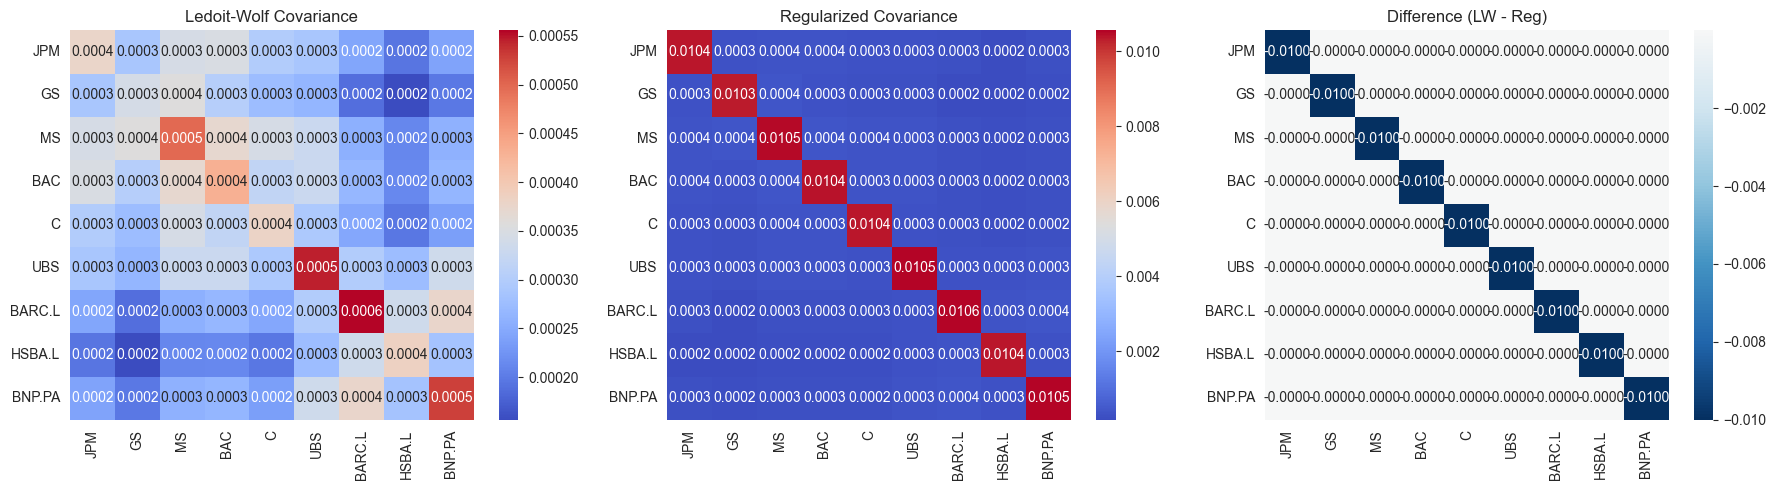

In [95]:
# Example: Using Ledoit-Wolf shrinkage estimator
from backtest.backtesting import Backtester

# Prepare data
data = obtain_data_with_fe()
tickers = [
    "JPM", "GS", "MS", "BAC", "C", "UBS", "BARC.L", "HSBA.L", "BNP.PA"
]

# Format data columns
data.columns = [f"{ticker}_{column}" for column, ticker in data.columns]
data.rename(columns={f"{ticker}_Adj_Close": f"{ticker}" for ticker in tickers}, inplace=True)

# Test 1: Ledoit-Wolf shrinkage
strategy_lw = FMMeanVariance(
    rolling_window=30,
    target_ret=0.0005,  # 0.05% daily target return
    rebalance_frequency=5,
    cov_method='ledoit_wolf',
    cov_lookback=252  # Use 1 year of data for covariance
)

print("Strategy with Ledoit-Wolf covariance estimator created")
print(f"Covariance method: {strategy_lw.cov_method}")
print(f"Lookback period: {strategy_lw.cov_lookback} days")

# Test 2: Regularized sample covariance
strategy_reg = FMMeanVariance(
    rolling_window=30,
    target_ret=0.0005,
    rebalance_frequency=5,
    cov_method='regularized',
    reg_lambda=0.01,  # Regularization parameter
    cov_lookback=252
)

print("\nStrategy with regularized sample covariance created")
print(f"Covariance method: {strategy_reg.cov_method}")
print(f"Regularization lambda: {strategy_reg.reg_lambda}")

# Test covariance matrix estimation directly
test_history = data.iloc[:100]  # Use first 100 days
cov_lw = strategy_lw._calculate_cov_matrix(tickers, test_history)
cov_reg = strategy_reg._calculate_cov_matrix(tickers, test_history)

print("\n" + "="*60)
print("Covariance Matrix Comparison")
print("="*60)
print(f"Ledoit-Wolf - Shape: {cov_lw.shape}, Condition number: {np.linalg.cond(cov_lw):.2f}")
print(f"Regularized - Shape: {cov_reg.shape}, Condition number: {np.linalg.cond(cov_reg):.2f}")

# Compare eigenvalues (for stability)
eig_lw = np.linalg.eigvalsh(cov_lw)
eig_reg = np.linalg.eigvalsh(cov_reg)

print(f"\nLedoit-Wolf eigenvalues range: [{eig_lw.min():.6f}, {eig_lw.max():.6f}]")
print(f"Regularized eigenvalues range: [{eig_reg.min():.6f}, {eig_reg.max():.6f}]")

# Visualize difference between covariance matrices
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Ledoit-Wolf
sns.heatmap(cov_lw, annot=True, fmt='.4f', cmap='coolwarm', ax=axes[0], 
            xticklabels=tickers, yticklabels=tickers)
axes[0].set_title('Ledoit-Wolf Covariance')

# Regularized
sns.heatmap(cov_reg, annot=True, fmt='.4f', cmap='coolwarm', ax=axes[1],
            xticklabels=tickers, yticklabels=tickers)
axes[1].set_title('Regularized Covariance')

# Difference
diff = cov_lw - cov_reg
sns.heatmap(diff, annot=True, fmt='.4f', cmap='RdBu_r', center=0, ax=axes[2],
            xticklabels=tickers, yticklabels=tickers)
axes[2].set_title('Difference (LW - Reg)')

plt.tight_layout()
plt.show()

In [100]:
# Run backtest with your choice of covariance method
# Uncomment and modify as needed
data = obtain_data_with_fe()
data.columns = [f"{ticker}_{column}" for column, ticker in data.columns]
data.rename(columns={f"{ticker}_Adj_Close": f"{ticker}" for ticker in tickers}, inplace=True)
data

# Using Ledoit-Wolf
# backtester_lw = Backtester(
#     data=data,
#     strategy=strategy_lw,
#     tradable_assets=tickers,
#     start_cash=100_000
# )
# results_lw = backtester_lw.run()

#Using Regularized Covariance  
backtester_reg = Backtester(
    data=data,
    strategy_fn=strategy_reg,
    strategy_name="FM Mean-Variance Regularized",
    tradable_assets=tickers,
    cash_start=100_000
)
results_reg = backtester_reg.run()

[*********************100%***********************]  9 of 9 completed


RuntimeError: Error in strategy.predict at index 29 date 2022-02-16 00:00:00: Found input variables with inconsistent numbers of samples: [270, 9]

## Summary: Covariance Estimation Methods

### 1. Ledoit-Wolf Shrinkage (`cov_method='ledoit_wolf'`)
**How it works:** Shrinks the sample covariance matrix toward a structured target (typically constant correlation model)

**Advantages:**
- Automatically determines optimal shrinkage intensity
- Well-suited for high-dimensional settings where n_observations ≈ n_assets
- Theoretically optimal under certain conditions
- No hyperparameters to tune

**When to use:**
- When you have limited historical data (e.g., n_observations < 10 * n_assets)
- When assets are highly correlated
- When you want a theoretically grounded approach

### 2. Regularized Sample Covariance (`cov_method='regularized'`)
**How it works:** Adds a diagonal term to the sample covariance: Σ_reg = Σ_sample + λ * I

**Advantages:**
- Simple and interpretable
- Direct control over regularization strength via `reg_lambda`
- Guarantees positive definiteness
- Computationally fast

**When to use:**
- When you have reasonable amount of data but want stability
- When you need explicit control over regularization
- When numerical stability is a concern

**Tuning `reg_lambda`:**
- Start with `reg_lambda = 0.01 * trace(Σ_sample) / n_assets`
- Larger values → more regularization → more stable but potentially biased
- Smaller values → less regularization → closer to sample covariance

### Key Parameters:
- `rolling_window`: Period for estimating expected returns (shorter = more reactive)
- `cov_lookback`: Historical window for covariance (typically 252 days = 1 year)
- `rebalance_frequency`: How often to reoptimize portfolio
- `target_ret`: Target expected return for mean-variance optimization